<h1>Credit Score Classification</h1>

<h3>In this notebook we will try to predict the creditworthiness of a person</h3>


# Part 1: Data Preparation, Cleaning and Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

## 1. Dataframes

In [2]:
train_original = pd.read_csv('train.csv')
train = train_original.copy()

test_original = pd.read_csv('test.csv')
test = test_original.copy()

/var/folders/v8/s752sg95209c7mrl_31hp1k80000gp/T/ipykernel_4645/3411222597.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv('train.csv')


## 2. Functions

In [3]:
def missing_values_percentage(df: pd.DataFrame):
    '''Function for calculating percentage of missing values in each columns of a dataframe'''

    missing_values = df.isnull().sum()
    
    missing_values = pd.DataFrame(missing_values)
    missing_values = missing_values.reset_index()
    missing_values.columns = ['Column','Count']
    
    list_missing_values = []
    
    for i in missing_values['Count']:
        percentage = (i / len(df)) * 100
        list_missing_values.append(percentage)
    
    list_missing_values = [round(num, 2) for num in list_missing_values]
    
    missing_values['Percentage (%)'] = list_missing_values
    
    print('Missing Values: ')
    print(missing_values.to_string())
    

In [4]:
def unique_values(df: pd.DataFrame):
    '''Function to extract unique values of a dataframe'''
    df_columns = df.columns.values
    unique_values = []
    for col in df_columns:
        unique_values.append(len(df[col].unique()))
    uniques = pd.DataFrame()
    uniques['Column Name'] = df_columns
    uniques['Count'] = unique_values
    print("Unique values: ")
    print(uniques.to_string())

In [5]:
def count_outliers(df: pd.DataFrame, feature: str):
    '''A function to count outliers'''
    
    # calculating the outlier boundaries
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    UBoundary = Q3 + 1.5 * IQR
    LBoundary = Q1 - 185 * IQR
    
    # counting outliers
    outlier_count = 0
    for i in df[feature]:
        if i > UBoundary or i < LBoundary:
            outlier_count=outlier_count+1
        else:
            pass
    
    print('Total outlier counts: ', outlier_count)

In [6]:
def remove_outliers(df: pd.DataFrame, feature: str):
    '''Function to remove outliers from the feature'''
    
    # calculating the outlier boundaries
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    UBoundary = Q3 + 1.5*IQR
    LBoundary = Q1 - 1.5*IQR
    
    new_list = []
    for i in df[feature]:
        if i > UBoundary or i < LBoundary:
            new_list.append(np.nan)
        else:
            new_list.append(i)
            
    # replacing the new list
    df[feature] = new_list
    
    print(feature, ' data distribution after dropping outliers')
    plt.hist(df[feature],)
    plt.title(feature + ' Data Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')

In [7]:
def mode_replacement(df: pd.DataFrame, reference: str, feature: str):
    '''Function to replace all entries in the dataset with the mode'''
    
    # Preparing dataframe
    lookup = df[[reference, feature]]
    
    # returning the mode of each subgroup that is present in the reference feature
    lookup = lookup.groupby(reference).agg(pd.Series.mode)
    
    # replacing all entries in each subgroup of the numerical list based on each subgroup's mode
    df[feature] = df[reference].map(lookup[feature])
    
    # eliminating any array-type value generated by the replacement method using only the first member of the array value
    newlist = []
    for i in range(len(df[feature])):
        # for float type members
        if type(df[feature][i]) == np.float64:
            newlist.append(df[feature][i])
        # for empty list members
        elif type(df[feature][i]) == np.ndarray and len(df[feature][i]) == 0:
            newlist.append(np.nan)
        # for non-empty list members
        elif type(df[feature][i]) == np.ndarray and len(df[feature][i]) != 0:
            newlist.append(df[feature][i][1])
    df[feature] = newlist
    
    # reconverting the feature into float to make sure the data type is correct
    df[feature].astype(float)
    
    # displaying the remaining missing value after the replacement and array elimination process
    remaining = df[feature].isnull().sum()
    print('Remaining', feature, 'missing values :', remaining)
    

In [8]:
def aggregrate_fill_na(df: pd.DataFrame, reference: str, feature: str):
    '''Function to fill NaN entries present in each subgroup of a 
    numerical list using the subgroup's mean +- standard deviation'''
    
    # preparing a dataframe containing both the feature that needs the 
    # nan filling and the reference feature that acts as the lookup table
    table = df[[reference, feature]]
    
    # locating the nan entries in the feature that needs the nan filling, followed by their reference value
    ref = df.loc[df[feature].isnull(), reference]
    
    # getting only the unique reference values
    ref = list(ref.unique())
    
    # creating a list with the same length as the reference values list containing empty values
    fe = []
    for i in range(len(ref)):
        fe.append(np.nan)
        
    # preparing the lookup table containing the reference values and the 
    # soon-to-be generated value associated to them
    
    featureLookUp = pd.DataFrame(list(zip(ref, fe)), columns=[reference, feature])
    
    # calculating the mean value of the feature that needs the nan filling
    featureMean = df[feature].mean()
    
    # calculating the std. dev. value of the feature that needs the nan filling
    featureStdDev = df[feature].std()
    
    # generating the lookup value in the lokup table
    featureLookUp[feature] = featureLookUp[feature]\
                                                .fillna(pd.Series(np.random.randint(
                                                         int(featureMean - featureStdDev),
                                                         int(featureMean + featureStdDev),
                                                         size=featureLookUp[feature].isnull().sum())))
    
    # filling in the nan entries in the feature that needs the nan filling with the reference to the lookup table
    df[feature] = df[feature].fillna(df[reference].map(featureLookUp.set_index(reference)[feature]))
    
    # checking if there are still missing values in the feature
    remaining = df[feature].isnull().sum()
    print('Remaining', feature, 'missing values :', remaining)

In [9]:
def uniquevalueprob(dataset, feature, excludeditem = None):
    # a function to get each unique value's count and portion in a feature
    
    # getting the feature's unique values
    global listUV
    listUV = list(dataset[feature].unique())
    listUV = [i for i in listUV if type(i) is not float]
    if excludeditem is not None:
        listUV.remove(excludeditem)
    else:
        listUV = listUV
    
    # getting the count of each unique value
    global listUVcount
    listUVcount = []
    for UV in listUV:
        UVcount = (dataset[feature] == UV).sum()
        listUVcount.append(UVcount)
    
    # calculating the total count of items in the feature
    totalcount = sum(listUVcount)
    
    # calculating the portion of each unique value
    global listUVportion
    listUVportion = []
    for item in listUVcount:
        UVportion = item / totalcount
        listUVportion.append(UVportion)
    
    # creating the report table
    table = pd.DataFrame(list(zip(listUV, listUVcount, listUVportion)))
    table.columns = [feature, 'Count', 'Portion']
    
    # displaying the report table
    print(table.sort_values(['Count', feature], 
                            ascending = [0,1]).to_string(index = False))

## 3. Data Exploration

In [10]:
# A quick look at the training & testing dataset
pd.set_option('display.max_columns', None)
print("\nTraining Data")
print("--"*40)
display(train.head())

print("\nTesting data")
print("--"*40)
display(test.head())

print('Rows x Columns of a training dataset: ', train.shape)
print('Rows x Columns of a testing dataset: ', test.shape)


Training Data
--------------------------------------------------------------------------------


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good



Testing data
--------------------------------------------------------------------------------


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,13.27,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,12.27,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,11.27,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,1,5.42,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


Rows x Columns of a training dataset:  (100000, 28)
Rows x Columns of a testing dataset:  (50000, 27)


In [11]:
# Overview of training data set
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

None

In [12]:
# Overview of testing data set
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

None

In [13]:
train.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [14]:
test.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,42502.000000,50000.000000,50000.000000,50000.000000,50000.000000,48965.000000,50000.000000,50000.000000
mean,4182.004291,16.838260,22.921480,68.772640,21.052640,30.080200,32.279581,1491.304305
std,3174.109304,116.396848,129.314804,451.602363,14.860397,196.984121,5.106238,8595.647887
min,303.645417,-1.000000,0.000000,1.000000,-5.000000,0.000000,20.509652,0.000000
25%,1625.188333,3.000000,4.000000,8.000000,10.000000,4.000000,28.061040,32.222388
50%,3086.305000,6.000000,5.000000,13.000000,18.000000,7.000000,32.280390,74.733349
75%,5934.189094,7.000000,7.000000,20.000000,28.000000,10.000000,36.468591,176.157491
max,15204.633333,1798.000000,1499.000000,5799.000000,67.000000,2593.000000,48.540663,82398.000000


### 3.1 Missing Values
<br>

In [15]:
# Missing values in training data set
missing_values_percentage(train)

Missing Values: 
                      Column  Count  Percentage (%)
0                         ID      0            0.00
1                Customer_ID      0            0.00
2                      Month      0            0.00
3                       Name   9985            9.98
4                        Age      0            0.00
5                        SSN      0            0.00
6                 Occupation      0            0.00
7              Annual_Income      0            0.00
8      Monthly_Inhand_Salary  15002           15.00
9          Num_Bank_Accounts      0            0.00
10           Num_Credit_Card      0            0.00
11             Interest_Rate      0            0.00
12               Num_of_Loan      0            0.00
13              Type_of_Loan  11408           11.41
14       Delay_from_due_date      0            0.00
15    Num_of_Delayed_Payment   7002            7.00
16      Changed_Credit_Limit      0            0.00
17      Num_Credit_Inquiries   1965            

In [16]:
# Missing values in testing data set
missing_values_percentage(test)

Missing Values: 
                      Column  Count  Percentage (%)
0                         ID      0            0.00
1                Customer_ID      0            0.00
2                      Month      0            0.00
3                       Name   5015           10.03
4                        Age      0            0.00
5                        SSN      0            0.00
6                 Occupation      0            0.00
7              Annual_Income      0            0.00
8      Monthly_Inhand_Salary   7498           15.00
9          Num_Bank_Accounts      0            0.00
10           Num_Credit_Card      0            0.00
11             Interest_Rate      0            0.00
12               Num_of_Loan      0            0.00
13              Type_of_Loan   5704           11.41
14       Delay_from_due_date      0            0.00
15    Num_of_Delayed_Payment   3498            7.00
16      Changed_Credit_Limit      0            0.00
17      Num_Credit_Inquiries   1035            

### 3.2 Duplicate entries
<br>

In [17]:
print("No. of duplicated entries in training data: ", train.duplicated().sum())
print("No. of duplicated entries in testing data: ", test.duplicated().sum())

No. of duplicated entries in training data:  0
No. of duplicated entries in testing data:  0


### 3.3 Unique Values
<br>

In [18]:
# Unique values in training data set
unique_values(train)

Unique values: 
                 Column Name   Count
0                         ID  100000
1                Customer_ID   12500
2                      Month       8
3                       Name   10140
4                        Age    1788
5                        SSN   12501
6                 Occupation      16
7              Annual_Income   18940
8      Monthly_Inhand_Salary   13236
9          Num_Bank_Accounts     943
10           Num_Credit_Card    1179
11             Interest_Rate    1750
12               Num_of_Loan     434
13              Type_of_Loan    6261
14       Delay_from_due_date      73
15    Num_of_Delayed_Payment     750
16      Changed_Credit_Limit    4384
17      Num_Credit_Inquiries    1224
18                Credit_Mix       4
19          Outstanding_Debt   13178
20  Credit_Utilization_Ratio  100000
21        Credit_History_Age     405
22     Payment_of_Min_Amount       3
23       Total_EMI_per_month   14950
24   Amount_invested_monthly   91050
25         Payment_Beh

In [19]:
# Unique values in testing data set
unique_values(test)

Unique values: 
                 Column Name  Count
0                         ID  50000
1                Customer_ID  12500
2                      Month      4
3                       Name  10140
4                        Age    976
5                        SSN  12501
6                 Occupation     16
7              Annual_Income  16121
8      Monthly_Inhand_Salary  12794
9          Num_Bank_Accounts    540
10           Num_Credit_Card    819
11             Interest_Rate    945
12               Num_of_Loan    263
13              Type_of_Loan   6261
14       Delay_from_due_date     73
15    Num_of_Delayed_Payment    444
16      Changed_Credit_Limit   3927
17      Num_Credit_Inquiries    751
18                Credit_Mix      4
19          Outstanding_Debt  12685
20  Credit_Utilization_Ratio  50000
21        Credit_History_Age    400
22     Payment_of_Min_Amount      3
23       Total_EMI_per_month  13144
24   Amount_invested_monthly  45451
25         Payment_Behaviour      7
26          

In [20]:
missing_values_percentage(train)

Missing Values: 
                      Column  Count  Percentage (%)
0                         ID      0            0.00
1                Customer_ID      0            0.00
2                      Month      0            0.00
3                       Name   9985            9.98
4                        Age      0            0.00
5                        SSN      0            0.00
6                 Occupation      0            0.00
7              Annual_Income      0            0.00
8      Monthly_Inhand_Salary  15002           15.00
9          Num_Bank_Accounts      0            0.00
10           Num_Credit_Card      0            0.00
11             Interest_Rate      0            0.00
12               Num_of_Loan      0            0.00
13              Type_of_Loan  11408           11.41
14       Delay_from_due_date      0            0.00
15    Num_of_Delayed_Payment   7002            7.00
16      Changed_Credit_Limit      0            0.00
17      Num_Credit_Inquiries   1965            

### 3.4 Data Exploration findings

<b> Dataframe Shape: </b> Training dataset has 100,000 entries while Testing dataset has 50,000 entries

<b>Incorrect Data Type</b>
<ul>
    <li><b>"Annual_Income"</b> should be int64</li>
    <li><b>"Num_of_Loan"</b> should be int64</li>
    <li><b>"Num_of_Delayed_Payment"</b> should be int64</li>
    <li><b>"Changed_Credit_Limit"</b> should be float64</li>
    <li><b>"Outstanding_Debt"</b> should be float64</li>
    <li><b>"Credit_History_Age"</b> should be float64</li>
    <li><b>"Amount_invested_monthly"</b> should be float64</li>
    <li><b>"Monthly_Balance"</b> should be float64</li>
</ul><br>

<b>Missing Values</b>
<ul>
    <li><b>"Name"</b>
    <li><b>"Monthly_Inhand_Salary"</b>
    <li><b>"Type_of_Loan"</b>
    <li><b>"Num_of_Delayed_Payment"</b>
    <li><b>"Num_Credit_Inquiries"</b>
    <li><b>"Credit_History_Age"</b>
    <li><b>"Amount_invested_monthly"</b>
    <li><b>"Monthly_Balance"</b>
</ul><br>

<b>Duplicated entries</b>: None

<b>Negative Values</b>
<ul>
    <li><b>"Num_Bank_Accounts"</b>
    <li><b>"Delay_from_due_date"</b>
</ul><br>

## 4. Featuring Engnieering: Data cleaning

### 4.1 Cleaning categorical features that should be numerical

In [21]:
train = train_original.copy()
test = test_original.copy()

In [22]:
# Categoprical features that are supposed to be numerical
features_to_convert = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 
           'Credit_History_Age', 'Amount_invested_monthly', 'Monthly_Balance']

# looking at the unique values of each feature
for col in features_to_convert:
    uniques = train[col].unique()
    print('Feature: \n',
          '\033[1m', col,'\033[0m', '\n',
          uniques, '\n' ,'--'*50, '\n')

Feature: 
  Age  
 ['23' '-500' '28_' ... '4808_' '2263' '1342'] 
 ---------------------------------------------------------------------------------------------------- 

Feature: 
  Annual_Income  
 ['19114.12' '34847.84' '34847.84_' ... '20002.88' '39628.99' '39628.99_'] 
 ---------------------------------------------------------------------------------------------------- 

Feature: 
  Num_of_Loan  
 ['4' '1' '3' '967' '-100' '0' '0_' '2' '3_' '2_' '7' '5' '5_' '6' '8' '8_'
 '9' '9_' '4_' '7_' '1_' '1464' '6_' '622' '352' '472' '1017' '945' '146'
 '563' '341' '444' '720' '1485' '49' '737' '1106' '466' '728' '313' '843'
 '597_' '617' '119' '663' '640' '92_' '1019' '501' '1302' '39' '716' '848'
 '931' '1214' '186' '424' '1001' '1110' '1152' '457' '1433' '1187' '52'
 '1480' '1047' '1035' '1347_' '33' '193' '699' '329' '1451' '484' '132'
 '649' '995' '545' '684' '1135' '1094' '1204' '654' '58' '348' '614'
 '1363' '323' '1406' '1348' '430' '153' '1461' '905' '1312' '1424' '1154'
 '95' '135

By looking at the above entries some of these entries contains no-numerical character like '-' or '_'. Also if you notice, Credit_History_Age feature entries in terms of years and months which needs to convert in months.

In [23]:
# Currently we are removing 'Credit_History_Age' from the features_to_convert, we'll handle it separately
if 'Credit_History_Age' in features_to_convert:
    features_to_convert.remove('Credit_History_Age')

# Removing '-' or '_' characters from the numerical data
for feature in features_to_convert:
    train[feature] = train[feature].str.strip('-_')
    test[feature] = test[feature].str.strip('-_')

# Replacing the empty space with np.NaN 
for feature in features_to_convert:
    train[feature] = train[feature].replace({'': np.nan})
    test[feature] = test[feature].replace({'': np.nan})

# Converting the categorical feature to float64
for feature in features_to_convert:
    train[feature] = train[feature].astype('float64')
    test[feature] = test[feature].astype('float64')
    
# Checking if the conversion is successfull or not
for feature in features_to_convert:
    print('Training data, \033[1m', feature, '\033[0m: ', train[feature].dtype)
    print('Testing data, \033[1m', feature, '\033[0m: ', test[feature].dtype, '\n')


Training data,  Age :  float64
Testing data,  Age :  float64 

Training data,  Annual_Income :  float64
Testing data,  Annual_Income :  float64 

Training data,  Num_of_Loan :  float64
Testing data,  Num_of_Loan :  float64 

Training data,  Num_of_Delayed_Payment :  float64
Testing data,  Num_of_Delayed_Payment :  float64 

Training data,  Changed_Credit_Limit :  float64
Testing data,  Changed_Credit_Limit :  float64 

Training data,  Outstanding_Debt :  float64
Testing data,  Outstanding_Debt :  float64 

Training data,  Amount_invested_monthly :  float64
Testing data,  Amount_invested_monthly :  float64 

Training data,  Monthly_Balance :  float64
Testing data,  Monthly_Balance :  float64 



### 4.2 Cleaning 'Credit_History_Age' feature to numerical data

In [24]:
# Handling 'Credit_History_Age' feature
train['Credit_History_Age'].head(5)

0    22 Years and 1 Months
1                      NaN
2    22 Years and 3 Months
3    22 Years and 4 Months
4    22 Years and 5 Months
Name: Credit_History_Age, dtype: object

Since the value is in Years and Months we will convert every entry to number of. months

In [25]:
# Converting 'Credit_History_Age' in training data
train_converted = []
for entry in train['Credit_History_Age']:
    str_entry = str(entry).split(' ')
    if(len(str_entry) > 1):
        entry = (float(str_entry[0]) * 12) + float(str_entry[3])
    train_converted.append(entry)
train['Credit_History_Age'] = train_converted
train['Credit_History_Age'].head(5)

0    265.0
1      NaN
2    267.0
3    268.0
4    269.0
Name: Credit_History_Age, dtype: float64

In [26]:
# Converting 'Credit_History_Age' in testing data
test_converted = []
for entry in test['Credit_History_Age']:
    str_entry = str(entry).split(' ')
    if(len(str_entry) > 1):
        entry = (float(str_entry[0]) * 12) + float(str_entry[3])
    test_converted.append(entry)
test['Credit_History_Age'] = test_converted
test['Credit_History_Age'].head(5)

0    273.0
1    274.0
2      NaN
3    276.0
4    327.0
Name: Credit_History_Age, dtype: float64

In [27]:
test_copy = test.copy()
train_copy = train.copy()

So far we have performed following tasks for numerical data
<ul>
    <li>Removed '-' & '_' from the data</li>
    <li>Replaced empty space with np.nan</li>
    <li>Converted several categorical data into numerical form (float)</li>
</ul>
Now, let's explore categorical data
</br></br>

## 5. Data Exploration 2: Categorical Features

### 5.1 General Overview

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              88592 non-null   ob

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  float64
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  float64
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  float64
 13  Type_of_Loan              44296 non-null  object 
 14  Delay_

In [30]:
# Storing categorical and numerical features in a separate lists
categorical_features = []
numerical_features = []
for feature in train.columns:
    if train[feature].dtype == 'object':
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)
print("\033[1mCategorical features\033[0m \n", categorical_features, '\n')
print("\033[1mNumerical features\033[0m \n", numerical_features, '\n')

Categorical features 
 ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score'] 

Numerical features 
 ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'] 



### 5.2 Spell check

In [31]:
# Exploring categorical data in training dataset
for feature in categorical_features:
    uniques = train[feature].unique()
    print('\033[1m', feature, '\033[0m\n', uniques, '\n', 'Unique entries: ', len(uniques), '\n')

 ID 
 ['0x1602' '0x1603' '0x1604' ... '0x25feb' '0x25fec' '0x25fed'] 
 Unique entries:  100000 

 Customer_ID 
 ['CUS_0xd40' 'CUS_0x21b1' 'CUS_0x2dbc' ... 'CUS_0xaf61' 'CUS_0x8600'
 'CUS_0x942c'] 
 Unique entries:  12500 

 Month 
 ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'] 
 Unique entries:  8 

 Name 
 ['Aaron Maashoh' nan 'Rick Rothackerj' ... 'Chris Wickhamm'
 'Sarah McBridec' 'Nicks'] 
 Unique entries:  10140 

 SSN 
 ['821-00-0265' '#F%$D@*&8' '004-07-5839' ... '133-16-7738' '031-35-0942'
 '078-73-5990'] 
 Unique entries:  12501 

 Occupation 
 ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect'] 
 Unique entries:  16 

 Type_of_Loan 
 ['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Auto Loan, Auto Loan, and Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto 

In [32]:
# Exploring categorical data in testing dataset
for feature in categorical_features[:-1]:
    uniques = test[feature].unique()
    print('\033[1m', feature, '\033[0m\n', uniques, '\n', 'Unique entries: ', len(uniques), '\n')

 ID 
 ['0x160a' '0x160b' '0x160c' ... '0x25fef' '0x25ff0' '0x25ff1'] 
 Unique entries:  50000 

 Customer_ID 
 ['CUS_0xd40' 'CUS_0x21b1' 'CUS_0x2dbc' ... 'CUS_0xaf61' 'CUS_0x8600'
 'CUS_0x942c'] 
 Unique entries:  12500 

 Month 
 ['September' 'October' 'November' 'December'] 
 Unique entries:  4 

 Name 
 ['Aaron Maashoh' 'Rick Rothackerj' 'Langep' ... 'Chris Wickhamm'
 'Sarah McBridec' 'Nicks'] 
 Unique entries:  10140 

 SSN 
 ['821-00-0265' '004-07-5839' '#F%$D@*&8' ... '133-16-7738' '031-35-0942'
 '078-73-5990'] 
 Unique entries:  12501 

 Occupation 
 ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect'] 
 Unique entries:  16 

 Type_of_Loan 
 ['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Auto Loan, Auto Loan, and Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan'
 'Payday Loa

From the above entries following are the findings:
<ul>
    <li>In the training dataset data is presented for 8 months i.e. from Jan to Aug and in the testing dataset data is presented for rest 4 months i.e. from Aep to Dec. Keeping this information in mind the correlation of ID matches with Customer_ID. [ (100000 / 12500) = 8 ]</li>
    <li>The "Name" feature should have 12,500 entries but it has only 10140 lacking 2360 entries.</li>
    <li>"SSN" features contains is having 1 extra entry with seemingly weird entry i.e. "#F%$D@*&8" </li>
    <li>"Occupation" feature has one unwanted value i.e. '_______' </li>
    <li>"Type_of_Loan" feature has list values and some cleaning will be required.</li>
    <li>"Credit_Mix" feature contains '_' which seems like undertermined </li>
    <li>"Payment_Behaviour" feature contains weird data compared to other entries </li>
</ul>


## 6. Data Cleaning Phase 2: Categorical Features

### 6.1 Categorical feature: Name

Currently in this scenario "Name" feature does not have any importance for training the classification model hence, we will drop the entire Name column from both the datasets

In [33]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

In [34]:
test_copy = test.copy()
train_copy = train.copy()

### 6.2 Categorical feature: SSN

In [35]:
print("No of. entries having #F%$D@*&8 in the SSN feature in training data: ",
      len(train.loc[train['SSN'] == '#F%$D@*&8']))
print("No of. entries having #F%$D@*&8 in the SSN feature in testing data: ",
      len(test.loc[test['SSN'] == '#F%$D@*&8']))

No of. entries having #F%$D@*&8 in the SSN feature in training data:  5572
No of. entries having #F%$D@*&8 in the SSN feature in testing data:  2828


Since there are many entries in the SSN feature we will replace #F%$D@*&8 with np.nan

In [36]:
# Replacing '#F%$D@*&8' with np.nan
train['SSN'] = train['SSN'].replace('#F%$D@*&8', np.nan)
test['SSN'] = test['SSN'].replace('#F%$D@*&8', np.nan)

Now that we have replace #F%$D@*&8 with NaN, we will fil up the NaN with some value. For this we are using mode in reference to Customer_ID since SSN is unique for every customer

In [37]:
# Replacing NaN value with mode in reference to Customer_ID
train['SSN'] = train['SSN'].fillna(train.groupby('Customer_ID')['SSN'].transform(lambda x: x.mode().iat[0]))
test['SSN'] = test['SSN'].fillna(test.groupby('Customer_ID')['SSN'].transform(lambda x: x.mode().iat[0]))

In [38]:
print("No. of NaN/missing values in SSN col.: ",len(train[train['SSN'].isna()]))

No. of NaN/missing values in SSN col.:  0


In [39]:
test_copy = test.copy()
train_copy = train.copy()

### 6.3 Categorical Feature: Occupation

We can see that Occupation column has missing values denoted by "______". Let's look at no. of missing entries

In [40]:
print("Missing Occupetion in training data: ", len(train[train['Occupation'] == '_______']))
print("Missing Occupetion in testing data : ", len(test[test['Occupation'] == '_______']))

Missing Occupetion in training data:  7062
Missing Occupetion in testing data :  3438


Let's convert missing values to NaN and then to NaN to frequently occurring occupation i.e. Mode

In [41]:
# Replacing missing values with NaN
train['Occupation'].replace('_______', np.NaN, inplace=True)
test['Occupation'].replace('_______', np.NaN, inplace=True)

In [42]:
train['Occupation'] = train['Occupation'].fillna(train.groupby('Customer_ID')['Occupation']
                                                 .transform(lambda x: x.mode().iat[0]))
test['Occupation'] = test['Occupation'].fillna(test.groupby('Customer_ID')['Occupation']
                                                 .transform(lambda x: x.mode().iat[0]))

In [43]:
print(train['Occupation'].unique(),'\n')
print(test['Occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect'] 

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


In [44]:
train_ver_1 = train.copy()
test_ver_1 = test.copy()

### 6.4 Categorical Feature: Type_of_Loan

In [45]:
train['Type_of_Loan'].unique()

array(['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
       'Credit-Builder Loan', 'Auto Loan, Auto Loan, and Not Specified',
       ..., 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan',
       'Payday Loan, Student Loan, Mortgage Loan, and Not Specified',
       'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan'],
      dtype=object)

Type_of_Loan consits of List though it contais String. 
Type_of_Loan will be extended as a separate feature consisting of boolean values. We will firat try to clean the format of the entries basically, converting strings into list

In [46]:
# Converting every entries to string
train['Type_of_Loan'] = train['Type_of_Loan'].astype('str')
test['Type_of_Loan'] = test['Type_of_Loan'].astype('str')


In [47]:
# Dropping the 'and' keyword from every entries
train['Type_of_Loan'] = [item.replace('and ', '') for item in train['Type_of_Loan']]
test['Type_of_Loan'] = [item.replace('and ', '') for item in test['Type_of_Loan']]

In [48]:
# Trimming the white space after comma(,)
train['Type_of_Loan'] = [item.replace(', ', ',') for item in train['Type_of_Loan']]
test['Type_of_Loan'] = [item.replace(', ', ',') for item in test['Type_of_Loan']]

In [49]:
# Converting string to list in each entry
train['Type_of_Loan'] = [item.split(',') for item in train['Type_of_Loan']]
test['Type_of_Loan'] = [item.split(',') for item in test['Type_of_Loan']]

Now let's convert each unique value of Type_of_Loan into separate features


<h4>a. Training dataframe</h4>
<br>

In [50]:
# Unique value counts (frequency) of each value
listUVcount = pd.Series([x for _list in train['Type_of_Loan'] for x in _list]).value_counts()
listUVcount

# Getting list of types of loan excludig nan
listUV = list(listUVcount[:-1].index)
listUV

# sum of all the unique values excluding nan
totalcount = sum(listUVcount[:-1])
totalcount

# calculating percentage of each unique value
listUVportion = []
for UVcount in listUVcount[:-1]:
    UVportion = UVcount / totalcount
    listUVportion.append(UVportion)
listUVportion

# creating dataframe of the above info
table = pd.DataFrame({'Value': listUV, 'Count': listUVcount[:-1].values, 'Portion': listUVportion})
table

,Value,Count,Portion
0,Payday Loan,40568,0.114830
1,Credit-Builder Loan,40440,0.114468
2,Not Specified,39616,0.112135
3,Home Equity Loan,39104,0.110686
4,Student Loan,38968,0.110301
5,Mortgage Loan,38936,0.110210
6,Personal Loan,38888,0.110075
7,Debt Consolidation Loan,38776,0.109757
8,Auto Loan,37992,0.107538


In [51]:
# Filling the missing values
train['Type_of_Loan'] = train['Type_of_Loan']\
                        .fillna(pd.Series(np.random.choice(listUV,
                                                           p = listUVportion,
                                                           size = len(train['Type_of_Loan']))))
# checking if there are still missing values in the Type_of_Loan feature
train['Type_of_Loan'].isnull().sum()

0

Now, let's convert each unique values of Type_of_Loan into separate features

In [52]:
# Transforming unique values into its own cols
transformed_y = mlb.fit_transform(train['Type_of_Loan'])

# Extracting array of all unique values
type_of_loan_cols = mlb.classes_
type_of_loan_cols

# Creating dataframe
df_type_of_loan = pd.DataFrame(transformed_y, columns=type_of_loan_cols).astype(bool)
df_type_of_loan

,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan,nan
0,True,True,False,True,False,False,False,True,False,False
1,True,True,False,True,False,False,False,True,False,False
2,True,True,False,True,False,False,False,True,False,False
3,True,True,False,True,False,False,False,True,False,False
4,True,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
99995,True,False,False,False,False,False,False,False,True,False
99996,True,False,False,False,False,False,False,False,True,False
99997,True,False,False,False,False,False,False,False,True,False
99998,True,False,False,False,False,False,False,False,True,False


In [53]:
#dropping nan column
df_type_of_loan.drop('nan', axis = 1, inplace = True)

In [54]:
#saving checkpoint
train_ver_2 = train.copy()

# concating df_type_of_loan dataframe to original training dataframe
train = pd.concat([train, df_type_of_loan], axis=1, ignore_index=False)

# moving "Credit_Score" column at last
temp = train['Credit_Score']
train.drop('Credit_Score', axis=1, inplace=True)
train['Credit_Score'] = temp


<h4>b. Testing dataframe</h4>
<br>

In [55]:
listUVcount = pd.Series([x for _list in test['Type_of_Loan'] for x in _list]).value_counts()
listUVcount

totalCount = sum(listUVcount[:-1].values)
totalCount

listUV = listUVcount[:-1].index
listUV

listUVportion = []
for count in listUVcount[:-1]:
    listUVportion.append(count / totalCount)
listUVportion

table = pd.DataFrame({'Type of Loan':listUVcount[:-1].index, 'Count':listUVcount[:-1].values,
                      'Portion': listUVportion})
table

,Type of Loan,Count,Portion
0,Payday Loan,20284,0.114830
1,Credit-Builder Loan,20220,0.114468
2,Not Specified,19808,0.112135
3,Home Equity Loan,19552,0.110686
4,Student Loan,19484,0.110301
5,Mortgage Loan,19468,0.110210
6,Personal Loan,19444,0.110075
7,Debt Consolidation Loan,19388,0.109757
8,Auto Loan,18996,0.107538


In [56]:
test['Type_of_Loan'] = test['Type_of_Loan']\
                        .fillna(pd.Series(np.random.choice(listUV,
                                                           p = listUVportion,
                                                           size = len(test['Type_of_Loan']))))

In [57]:
df_type_of_loan = pd.DataFrame(mlb.fit_transform(test['Type_of_Loan']), columns=mlb.classes_).astype(bool)
df_type_of_loan.drop('nan', axis=1, inplace=True)
df_type_of_loan

,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,True,True,False,True,False,False,False,True,False
1,True,True,False,True,False,False,False,True,False
2,True,True,False,True,False,False,False,True,False
3,True,True,False,True,False,False,False,True,False
4,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
49995,True,False,False,False,True,False,False,True,True
49996,True,False,False,False,False,False,False,False,True
49997,True,False,False,False,False,False,False,False,True
49998,True,False,False,False,False,False,False,False,True


In [58]:
test_ver_2 = test.copy()
test = pd.concat([test, df_type_of_loan], axis=1, ignore_index=False)

### 6.4 Categorical Feature: Payment_Behaviour
<br>

In [59]:
train['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: Payment_Behaviour, dtype: int64

In [60]:
test['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      12694
High_spent_Medium_value_payments     8922
High_spent_Large_value_payments      6844
Low_spent_Medium_value_payments      6837
High_spent_Small_value_payments      5651
Low_spent_Large_value_payments       5252
!@9#%8                               3800
Name: Payment_Behaviour, dtype: int64

Here we can see both train and testing dataset contains unwanted data i.e. '!@9#%8'. So, let's clean those unwanted data and replace it with the mode

In [61]:
# replacing '!@9#%8' with NaN
train['Payment_Behaviour'].replace('!@9#%8', np.nan, inplace=True)
test['Payment_Behaviour'].replace('!@9#%8', np.nan, inplace=True)

In [62]:
# filling NaN with the mode
train['Payment_Behaviour'] = train['Payment_Behaviour'].fillna(pd.Series(train.groupby('Customer_ID')['Payment_Behaviour']
                                            .transform(lambda x: x.mode().iat[0])))
test['Payment_Behaviour'] = test['Payment_Behaviour'].fillna(pd.Series(test.groupby('Customer_ID')['Payment_Behaviour']
                                            .transform(lambda x: x.mode().iat[0])))

In [63]:
train['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      27767
High_spent_Medium_value_payments    19366
High_spent_Large_value_payments     15348
Low_spent_Medium_value_payments     14621
High_spent_Small_value_payments     11980
Low_spent_Large_value_payments      10918
Name: Payment_Behaviour, dtype: int64

In [64]:
test['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      13363
High_spent_Medium_value_payments     9946
High_spent_Large_value_payments      7970
Low_spent_Medium_value_payments      7115
High_spent_Small_value_payments      6082
Low_spent_Large_value_payments       5524
Name: Payment_Behaviour, dtype: int64

In [65]:
train_ver_3 = train.copy()
test_ver_3 = test.copy()

### 6.5 Categorical Feature: Credit_Mix
<br>

In [66]:
train['Credit_Mix'].value_counts()

Standard    36479
Good        24337
_           20195
Bad         18989
Name: Credit_Mix, dtype: int64

As we can see 'Credit_Mix' column also  consists of unwanted data i.e '_'.  So, let's fill those missing values with mode

In [67]:
# Replacing _ with nan
train['Credit_Mix'] = train['Credit_Mix'].replace('_', np.nan)
test['Credit_Mix'] = test['Credit_Mix'].replace('_', np.nan)

In [68]:
# counting the portion of each unique value
uniquevalueprob(train, 'Credit_Mix')
print('\n')
uniquevalueprob(test, 'Credit_Mix')

Credit_Mix  Count  Portion
  Standard  36479 0.457102
      Good  24337 0.304956
       Bad  18989 0.237942


Credit_Mix  Count  Portion
  Standard  18379 0.457246
      Good  12260 0.305013
       Bad   9556 0.237741


In [69]:
# filling in the remaining missing values with the unique value probability
train['Credit_Mix'] = train['Credit_Mix']\
                      .fillna(pd.Series(np.random.choice(listUV,
                      p = listUVportion, 
                      size = len(train))))
test['Credit_Mix'] = test['Credit_Mix']\
                     .fillna(pd.Series(np.random.choice(listUV,
                     p = listUVportion, 
                     size = len(test))))

In [70]:
train['Credit_Mix'].value_counts()

Standard    45563
Good        30518
Bad         23919
Name: Credit_Mix, dtype: int64

In [71]:
train_ver_4 = train.copy()
test_ver_4 = test.copy()

In [72]:
test['Credit_Mix'].isna().sum()

0

### 6.6 Summary
<br>

<ol>
      <li><b>Name</b></li>
      <ul>
        <li>Dropped Name feature</li>
      </ul><br>
      <li><b>SSN</b></li>
      <ul>
        <li>Replaced weird data with np.nan</li>
        <li>Replaced np.nan values with the mode of SSN value corresponding to customer</li>
      </ul><br>
      <li><b>Occupation</b></li>
      <ul>
        <li>Replaced '____' with np.nan</li>
        <li>Replaced np.nan values with the mode of Occupation value corresponding to customer</li>
      </ul><br>
      <li><b>Type_of_Loan</b></li>
      <ul>
        <li>Converted string entries to list</li>
        <li>Converted each uniqe values of Type_of_loan feature to separate feature column</li>
      </ul><br>
      <li><b>Payment_Behaviour</b></li>
      <ul>
        <li>Replaced weird data with np.nan</li>
        <li>Replaced np.nan values with the mode of Payment_Behaviour value corresponding to customer</li>
      </ul><br>
      <li><b>Credit_Mix</b></li>
      <ul>
        <li>Replaced '_' with np.nan</li>
        <li>Replaced np.nan values with the mode of Credit_Mix value corresponding to customer</li>
      </ul>
</ol>

## 7. Data Exploration Pahse 3: Numerical Features

In [73]:
train[numerical_features].describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,1.000000e+05,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,90970.000000,100000.000000,95521.000000,9.713200e+04
mean,119.509700,1.764157e+05,4194.170850,17.091280,22.47443,72.466040,10.761960,21.068780,30.946268,10.465678,27.754251,1426.220376,32.285173,221.195405,1403.118217,637.412998,3.088580e+22
std,684.757313,1.429618e+06,3183.686167,117.404834,129.05741,466.422621,61.789933,14.860104,226.028754,6.670732,193.177339,1155.129026,5.116875,99.741364,8306.041270,2043.319327,3.208492e+24
min,14.000000,7.005930e+03,303.645417,-1.000000,0.00000,1.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,7.759665e-03
25%,25.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,2.000000,10.000000,9.000000,5.350000,3.000000,566.072500,28.052567,144.000000,30.306660,74.534002,2.700037e+02
50%,34.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,219.000000,69.249473,135.925682,3.364770e+02
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,6.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,302.000000,161.224249,265.731733,4.696852e+02
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,404.000000,82331.000000,10000.000000,3.333333e+26


In [74]:
test[numerical_features].describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,50000.000000,5.000000e+04,42502.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,46502.000000,48941.000000,48965.000000,50000.000000,50000.000000,45530.000000,50000.000000,47729.000000,4.943800e+04
mean,118.994420,1.663342e+05,4182.004291,16.838260,22.921480,68.772640,11.299360,21.052640,30.910369,10.458053,30.080200,1426.220376,32.279581,227.251175,1491.304305,641.654795,4.045471e+22
std,678.133254,1.351965e+06,3174.109304,116.396848,129.314804,451.602363,65.483498,14.860397,221.507473,6.651572,196.984121,1155.134801,5.106238,99.554366,8595.647887,2053.895420,3.671994e+24
min,14.000000,7.005930e+03,303.645417,-1.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.000000,0.000000,0.230000,20.509652,10.000000,0.000000,0.000000,1.034022e-01
25%,25.000000,1.945333e+04,1625.188333,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.360000,4.000000,566.072500,28.061040,151.000000,32.222388,74.529270,2.705032e+02
50%,34.000000,3.757782e+04,3086.305000,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.410000,7.000000,1166.155000,32.280390,225.000000,74.733349,135.590430,3.370127e+02
75%,43.000000,7.281702e+04,5934.189094,7.000000,7.000000,20.000000,6.000000,28.000000,18.000000,14.800000,10.000000,1945.962500,36.468591,307.000000,176.157491,266.892228,4.709267e+02
max,8688.000000,2.413726e+07,15204.633333,1798.000000,1499.000000,5799.000000,1496.000000,67.000000,4399.000000,36.650000,2593.000000,4998.070000,48.540663,408.000000,82398.000000,10000.000000,3.333333e+26


### 7.1 Data Distribution Visualization

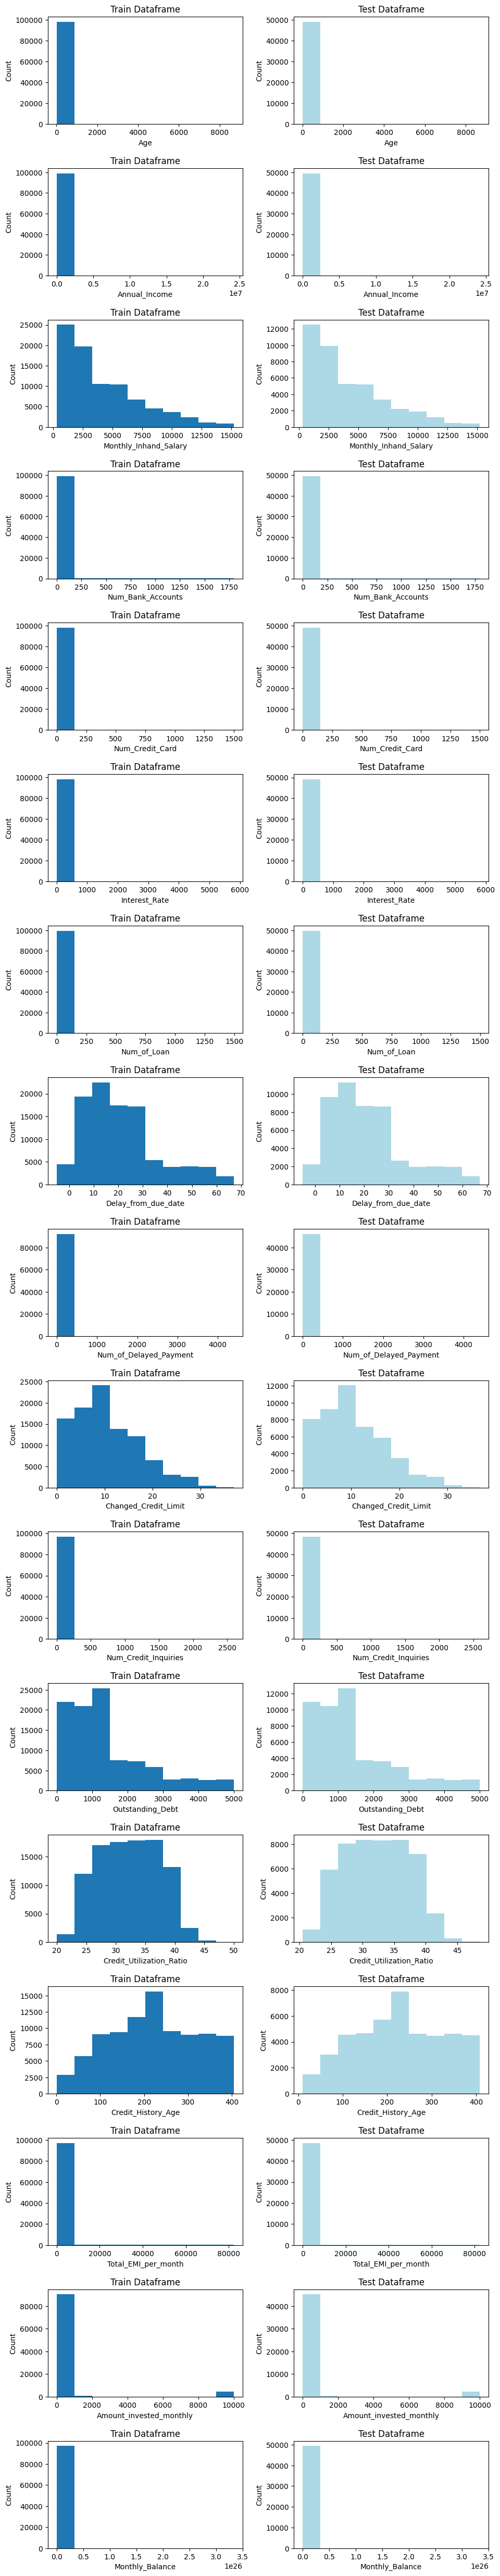

In [75]:
fig, axes = plt.subplots(17, 2, figsize = (10, 50))
fig.tight_layout(pad = 4)

# plotting the data visualization
for i in range(len(numerical_features)):
    axes[i, 0].hist(train[numerical_features[i]])
    axes[i, 0].set_title('Train Dataframe')
    axes[i, 0].set_xlabel(numerical_features[i])
    axes[i, 0].set_ylabel('Count')
    
    axes[i, 1].hist(test[numerical_features[i]],color = 'lightblue')
    axes[i, 1].set_title('Test Dataframe')
    axes[i, 1].set_xlabel(numerical_features[i])
    axes[i, 1].set_ylabel('Count')
plt.show()

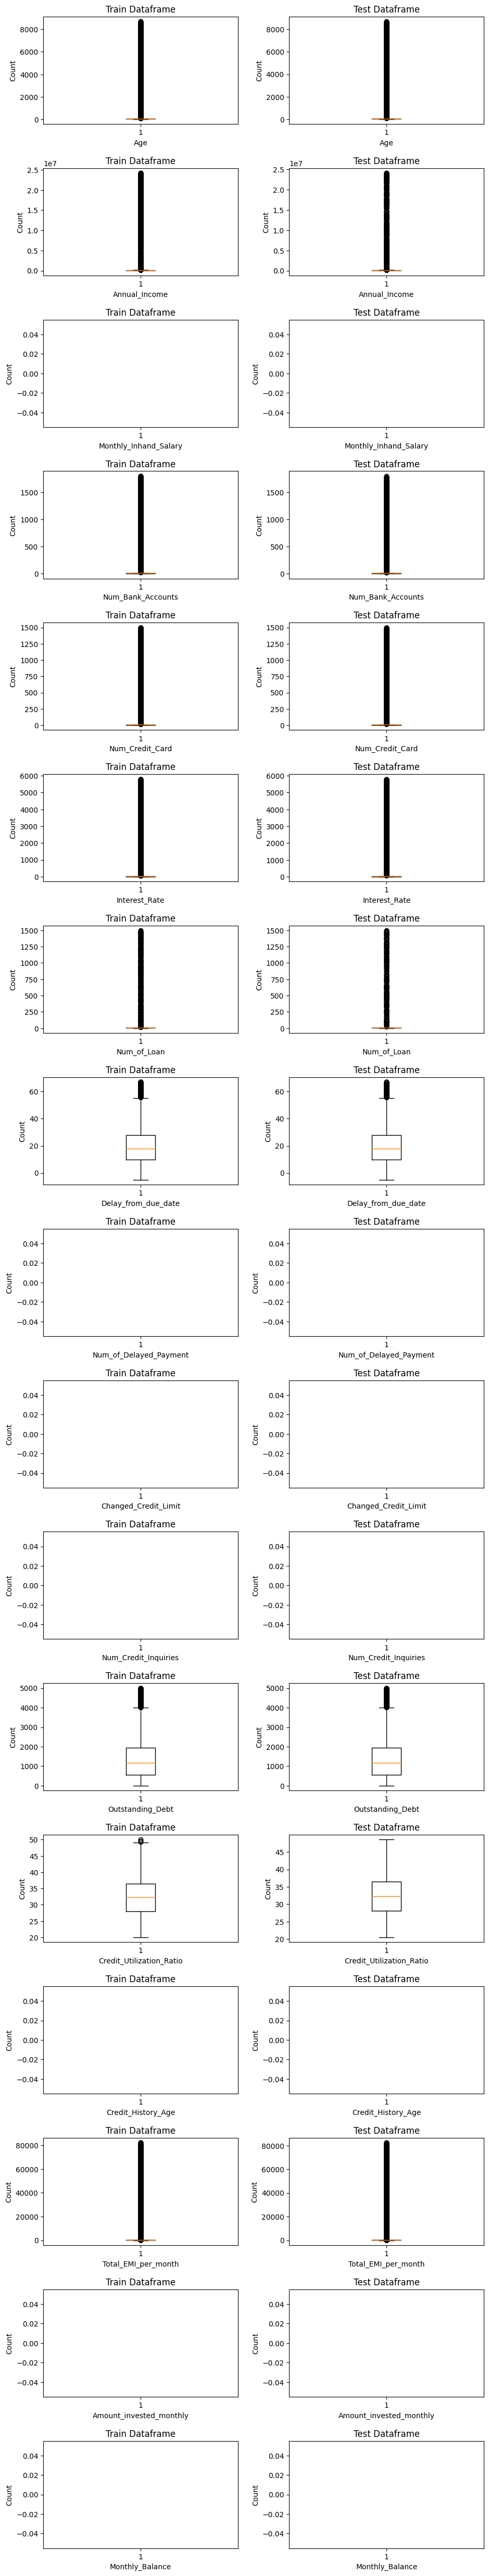

In [76]:
fig, axes = plt.subplots(17, 2, figsize = (10, 50))
fig.tight_layout(pad = 4)

# plotting the data visualization
for i in range(len(numerical_features)):
    axes[i, 0].boxplot(train[numerical_features[i]])
    axes[i, 0].set_title('Train Dataframe')
    axes[i, 0].set_xlabel(numerical_features[i])
    axes[i, 0].set_ylabel('Count')
    
    axes[i, 1].boxplot(test[numerical_features[i]])
    axes[i, 1].set_title('Test Dataframe')
    axes[i, 1].set_xlabel(numerical_features[i])
    axes[i, 1].set_ylabel('Count')
plt.show()

In [77]:
for feature in numerical_features:
    print('Feature: ', feature, '\n',
          'NaN count: ',train[feature].isna().sum())
    print()

Feature:  Age 
 NaN count:  0

Feature:  Annual_Income 
 NaN count:  0

Feature:  Monthly_Inhand_Salary 
 NaN count:  15002

Feature:  Num_Bank_Accounts 
 NaN count:  0

Feature:  Num_Credit_Card 
 NaN count:  0

Feature:  Interest_Rate 
 NaN count:  0

Feature:  Num_of_Loan 
 NaN count:  0

Feature:  Delay_from_due_date 
 NaN count:  0

Feature:  Num_of_Delayed_Payment 
 NaN count:  7002

Feature:  Changed_Credit_Limit 
 NaN count:  2091

Feature:  Num_Credit_Inquiries 
 NaN count:  1965

Feature:  Outstanding_Debt 
 NaN count:  0

Feature:  Credit_Utilization_Ratio 
 NaN count:  0

Feature:  Credit_History_Age 
 NaN count:  9030

Feature:  Total_EMI_per_month 
 NaN count:  0

Feature:  Amount_invested_monthly 
 NaN count:  4479

Feature:  Monthly_Balance 
 NaN count:  2868



### 7.2 Summary

<ol>
    <li>There are total 7 features <b>(Monthly_Inhand_Salary, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Credit_History_Age, Amount_invested_monthly, Monthly_Balance)</b> having missing values (NaN)</li>
    <li>There are total 12 features <b>(Age, Annual_Income, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Total_EMI_per_month, Amount_invested_monthly, and Monthly_Balance )</b> having abnormal maximum values (upper outliers).</li>
    <li>Num_of_Loan feature needs to be updated in reference to Type_ofLoan feature.</li>
</ol>

## 7. Data clean and engineering phase 3: Numerical features

In [78]:
train['Age'].unique()

array([  23.,  500.,   28., ..., 4808., 2263., 1342.])

### 7.1 Numerical Featrure: Age

In the age feature we can find abnormal values like 500, 7580, 995, etc. But if we look closely then we come to know the other values Age values for the same Customer_ID are valid. So we can replace all the abnormal values with the mode of the Age corresponding to that customer.

In [79]:
# Converting entries to string
TrainAge = pd.DataFrame([train['Customer_ID'], train['Age']]).transpose()
TestAge = pd.DataFrame([test['Customer_ID'], test['Age']]).transpose()

In [80]:
# Getting Customer_ID having Ages that are grater than 100 
(TrainAge[TrainAge['Age'] > 100])['Customer_ID'].head()

2       CUS_0xd40
56     CUS_0x5407
113     CUS_0xff4
122    CUS_0x33d2
219    CUS_0x3edc
Name: Customer_ID, dtype: object

In [81]:
# Checking other Age values of a customer having abnormal Age
TrainAge.groupby('Customer_ID').get_group('CUS_0xd40')

,Customer_ID,Age
0,CUS_0xd40,23.0
1,CUS_0xd40,23.0
2,CUS_0xd40,500.0
3,CUS_0xd40,23.0
4,CUS_0xd40,23.0
5,CUS_0xd40,23.0
6,CUS_0xd40,23.0
7,CUS_0xd40,23.0


In [82]:
# Ages that are grater than 100 
TestAge[TestAge['Age'] > 100]

,Customer_ID,Age
22,CUS_0x95ee,1694.0
34,CUS_0x4157,914.0
131,CUS_0x95b5,500.0
161,CUS_0xb5ff,3193.0
172,CUS_0xc65,339.0
...,...,...
49878,CUS_0x4a8f,7168.0
49881,CUS_0x1b07,5227.0
49935,CUS_0x1d18,7910.0
49986,CUS_0xf16,5826.0


In [83]:
# Replacing abnormal age values with the mode in reference to Customer_ID
TrainAge['Age'] = pd.Series(train.groupby('Customer_ID')['Age'].transform(lambda x: x.mode().iat[0]))
TestAge['Age'] = pd.Series(test.groupby('Customer_ID')['Age'].transform(lambda x: x.mode().iat[0]))

In [84]:
# Checking for any abnormal values
print('No. of entries having 4 digits in training data: ',len(TrainAge[TrainAge.Age >= 110]))
print('No. of entries having 4 digits in testing data: ',len(TestAge[TestAge.Age >= 110]))

No. of entries having 4 digits in training data:  0
No. of entries having 4 digits in testing data:  8


Still, testing data has 1 customer who is having abnormal value. Let's fix it.

In [85]:
# Getting Customer_ID having abnormal values
cust_age = list(TestAge[TestAge['Age'] > 110]['Customer_ID'].unique())
cust_age

['CUS_0x3385', 'CUS_0x8e89']

In [86]:
# Getting the Age values from original dataset
cust_age_dict = {}
for val in cust_age:
    min_val = test[test['Customer_ID'] == val]['Age'].min()
    cust_age_dict[val] = min_val
cust_age_dict

{'CUS_0x3385': 26.0, 'CUS_0x8e89': 32.0}

In [87]:
for key in cust_age_dict.keys():
    TestAge.loc[TestAge['Customer_ID'] == key, 'Age'] = cust_age_dict[key]

In [88]:
# Checking for any abnormal values
TestAge[TestAge['Age'] > 110]['Customer_ID'].unique()

array([], dtype=object)

In [89]:
# Assigning cleaned Age data to original dataset
train['Age'] = TrainAge['Age']
test['Age'] = TestAge['Age']

In [90]:
# Saving checkpoint
train_ver_5 = train.copy()
test_ver_5 = test.copy()

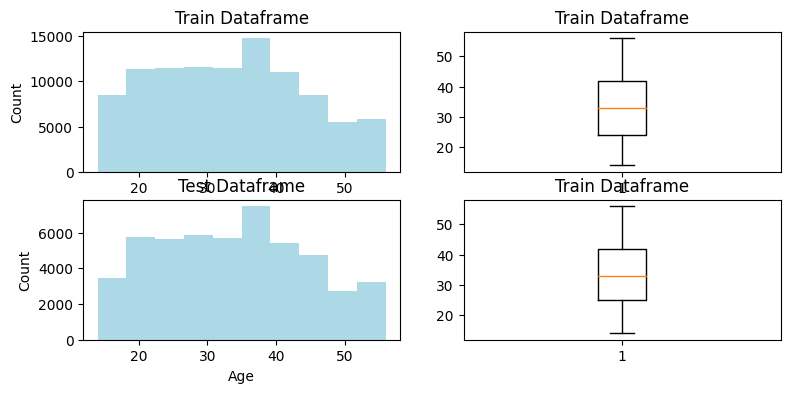

In [91]:
fig, axes = plt.subplots(2, 2, figsize = (9, 4))


# creating histogram plots
axes[0, 0].hist(train['Age'],
             color = 'lightblue')
axes[0, 1].boxplot(train['Age'])

axes[1, 0].hist(test['Age'],
             color = 'lightblue')
axes[1, 1].boxplot(test['Age'])

# setting plot information
axes[0, 0].set_title('Train Dataframe')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')

axes[0, 1].set_title('Train Dataframe')

axes[1, 0].set_title('Test Dataframe')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Count')

axes[1, 1].set_title('Train Dataframe')
plt.show()

### 7.2 Numerical feature: Annual_Income

Annual Income contains some upper outliers but no missing value. So, let's deal with outliers 

In [92]:
count_outliers(train, 'Annual_Income')
count_outliers(test, 'Annual_Income')

Total outlier counts:  2783
Total outlier counts:  1390


Annual_Income  data distribution after dropping outliers


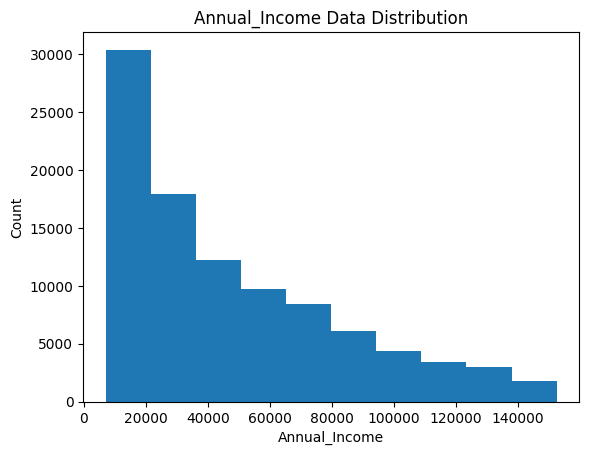

In [93]:
# dropping the outliers in the training dataframe
remove_outliers(train, 'Annual_Income')

Annual_Income  data distribution after dropping outliers


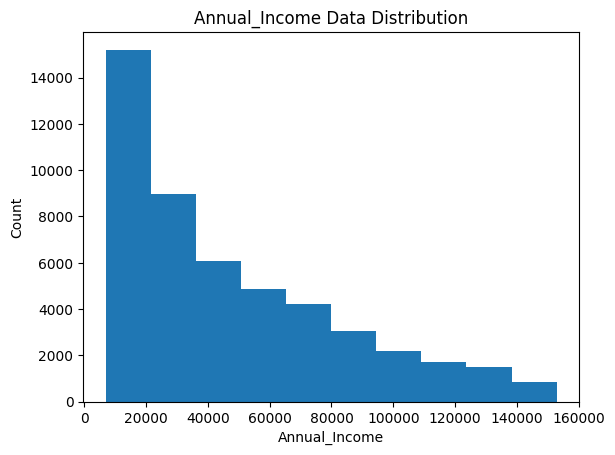

In [94]:
# dropping the outliers in the testing dataframe
remove_outliers(test, 'Annual_Income')

The Annual_Income values per customer should share same values, since the data collection only spans over a period of eight months. This is based on the assumption that each customer did not change occupation during the data collection period. For practicality purpose, the eight Annual_Income values per customer will share a same value.

In [95]:
# Replacing Annual_Income of each customer using each customer's Annual_Income Mode
print('Train data')
mode_replacement(train, 'Customer_ID', 'Annual_Income')

print('Test data')
mode_replacement(test, 'Customer_ID', 'Annual_Income')

Train data
Remaining Annual_Income missing values : 1800
Test data
Remaining Annual_Income missing values : 896


There are still 2432 (or 304 customers) entries in Training data and 896 (or 112 customers) entries in Testing data missing for Annual_Income values. So, let's fillup those missing entries

In [96]:
# filling in the remaining Annual_Income missing values
print(' Train dataframe: ')
aggregrate_fill_na(train, 'Customer_ID', 'Annual_Income')

print('\n', 'Test dataframe: ')
aggregrate_fill_na(test, 'Customer_ID', 'Annual_Income')

 Train dataframe: 
Remaining Annual_Income missing values : 0

 Test dataframe: 
Remaining Annual_Income missing values : 0


### 7.3 Numerical Feature: Monthly_Inhand_Salary

There are no outliers as such in the Monthly_Inhand_Salary feature. However, there are some missing values that needs to be dealt with. 

In [97]:
# Replacing Monthly_Inhand_Salary of each customer using each customer's Monthly_Inhand_Salary Mode
print('Train Data')
mode_replacement(train, 'Customer_ID', 'Monthly_Inhand_Salary')

print('Test Data')
mode_replacement(test, 'Customer_ID', 'Monthly_Inhand_Salary')

Train Data
Remaining Monthly_Inhand_Salary missing values : 0
Test Data
Remaining Monthly_Inhand_Salary missing values : 28


Still there are 28 entries (or 7 customers) in test data with totall missing values.

In [98]:
# filling in the remaining Monthly_Inhand_Salary missing values
print('Train dataframe:')
aggregrate_fill_na(train, 'Customer_ID', 'Monthly_Inhand_Salary')

print('\nTest Daatframe:')
aggregrate_fill_na(test, 'Customer_ID', 'Monthly_Inhand_Salary')

Train dataframe:
Remaining Monthly_Inhand_Salary missing values : 0

Test Daatframe:
Remaining Monthly_Inhand_Salary missing values : 0


### 7.4 Numerical Feature: Num_Bank_Accounts

By looking at the previous histogram and box plot we can say that there are some outliers present for Num_Bank_Accounts. So, let's deal with outliers first.

In [99]:
# counting outliers
print('Training data')
count_outliers(train, 'Num_Bank_Accounts')

print('\nTesting data')
count_outliers(test, 'Num_Bank_Accounts')

Training data
Total outlier counts:  1315

Testing data
Total outlier counts:  635


Num_Bank_Accounts  data distribution after dropping outliers


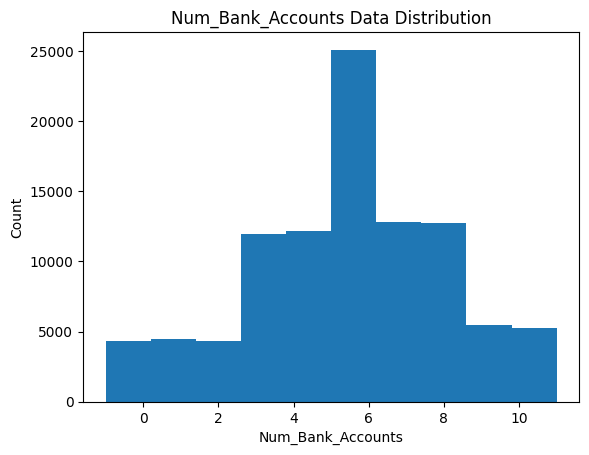

In [100]:
# removing outliers from training data
remove_outliers(train, 'Num_Bank_Accounts')

Num_Bank_Accounts  data distribution after dropping outliers


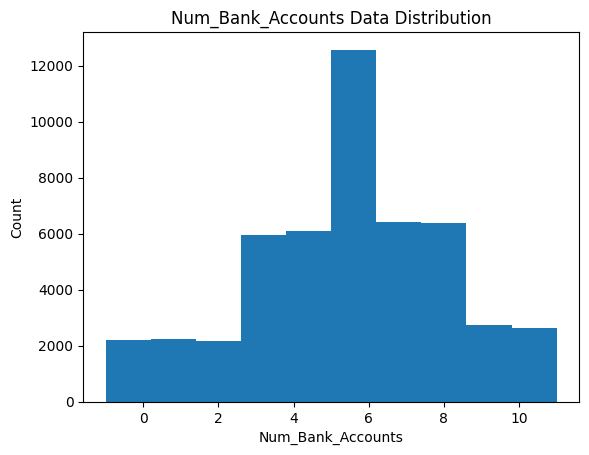

In [101]:
# removing outliers from testing data
remove_outliers(test, 'Num_Bank_Accounts')

In [102]:
# replacing 'Num_Bank_Accounts' entries with the mode
print('Training data:')
mode_replacement(train, 'Customer_ID', 'Num_Bank_Accounts')

print('\nTesting data:')
mode_replacement(test, 'Customer_ID', 'Num_Bank_Accounts')

Training data:
Remaining Num_Bank_Accounts missing values : 0

Testing data:
Remaining Num_Bank_Accounts missing values : 0


### 7.5 Numerical Feature: Num_Credit_Card

By looking at the previous histogram and box plot we can say that there are some outliers present for Num_Credit_Card. So, let's deal with outliers first.

In [103]:
# counting outliers
print('Training data')
count_outliers(train, 'Num_Credit_Card')

print('\nTesting data')
count_outliers(test, 'Num_Credit_Card')

Training data
Total outlier counts:  2271

Testing data
Total outlier counts:  1179


Training data
Num_Credit_Card  data distribution after dropping outliers


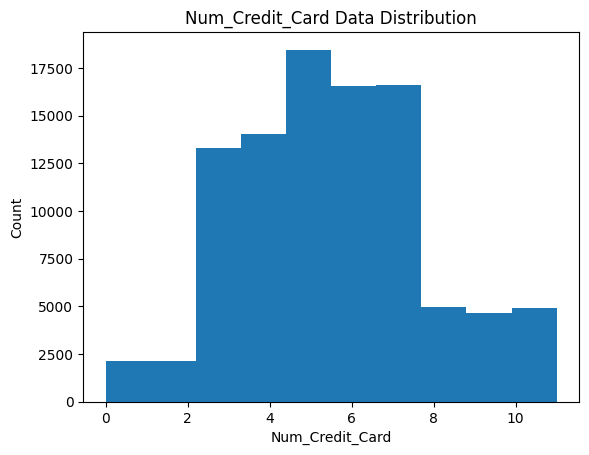

In [104]:
# Removing outliers from training data
print('Training data')
remove_outliers(train, 'Num_Credit_Card')


Testing data
Num_Credit_Card  data distribution after dropping outliers


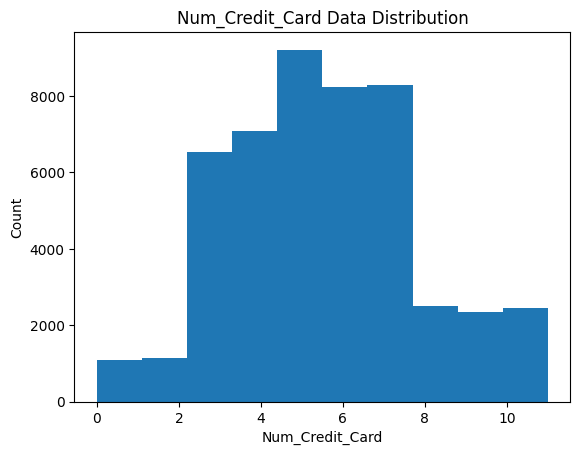

In [105]:
# Removing outliers from testing data
print('\nTesting data')
remove_outliers(test, 'Num_Credit_Card')

In [106]:
# replacing 'Num_Credit_Card' entries with the mode
print('Training data:')
mode_replacement(train, 'Customer_ID', 'Num_Credit_Card')

print('\nTesting data:')
mode_replacement(test, 'Customer_ID', 'Num_Credit_Card')

Training data:
Remaining Num_Credit_Card missing values : 0

Testing data:
Remaining Num_Credit_Card missing values : 0


### 7.6 Numerical Feature: Interest_Rate
By looking at the previous histogram and box plot we can say that there are some outliers present for Interest_Rate. So, let's deal with outliers first.

In [107]:
# counting outliers
print('Training data')
count_outliers(train, 'Interest_Rate')

print('\nTesting data')
count_outliers(test, 'Interest_Rate')

Training data
Total outlier counts:  2034

Testing data
Total outlier counts:  966


Training data
Interest_Rate  data distribution after dropping outliers


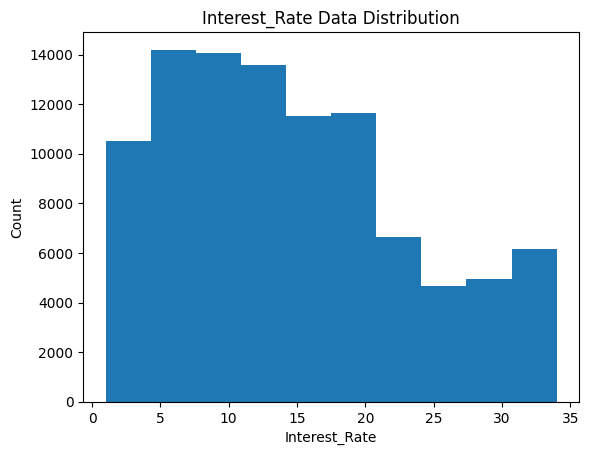

In [108]:
# Removing outliers from training data
print('Training data')
remove_outliers(train, 'Interest_Rate')


Testing data
Interest_Rate  data distribution after dropping outliers


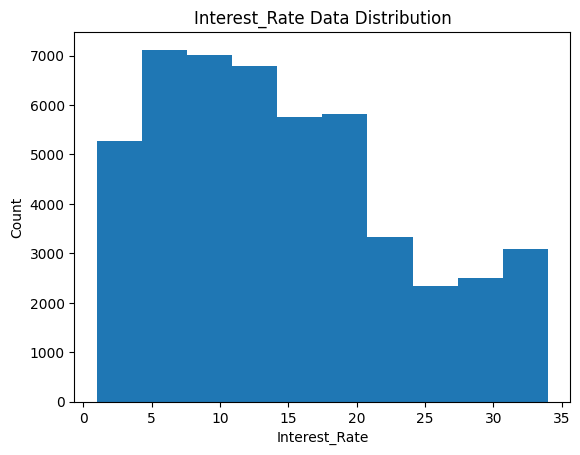

In [109]:
# Removing outliers from testing data
print('\nTesting data')
remove_outliers(test, 'Interest_Rate')

In [110]:
# replacing 'Num_Credit_Card' entries with the mode
print('Training data:')
mode_replacement(train, 'Customer_ID', 'Interest_Rate')

print('\nTesting data:')
mode_replacement(test, 'Customer_ID', 'Interest_Rate')

Training data:
Remaining Interest_Rate missing values : 0

Testing data:
Remaining Interest_Rate missing values : 0


### 7.7 Numerical Feature: Num_of_Loan
The Num_of_Loan feature is dependent on Type_of_Loan feature. So, we will be updating Num_of_loan feature according to Type_of_Loan

In [111]:
# Initializing empty list 
trainLoanList = []
testLoanList = []

# Counting the Type_of_Loan in each entry
for row in train['Type_of_Loan']:
    trainLoanList.append(len(row))

for row in test['Type_of_Loan']:
    testLoanList.append(len(row))

# Assigning new counts of Num_of_Loan
train['Num_of_Loan'] = trainLoanList
test['Num_of_Loan'] = testLoanList

### 7.8 Numerical Feature: Num_of_Delayed_Payment
By looking at the previous histogram and box plot we can say that there are some outliers present for Num_of_Delayed_Payment. So, let's deal with outliers first.

In [112]:
# counting outliers
print('Training data')
count_outliers(train, 'Num_of_Delayed_Payment')

print('\nTesting data')
count_outliers(test, 'Num_of_Delayed_Payment')

Training data
Total outlier counts:  736

Testing data
Total outlier counts:  395


Training data
Num_of_Delayed_Payment  data distribution after dropping outliers


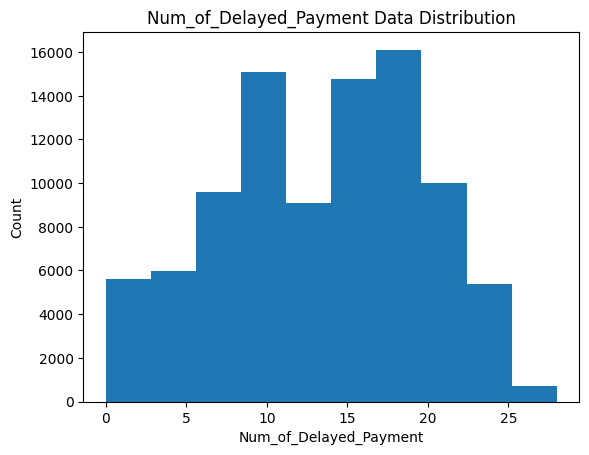

In [113]:
# Removing outliers from training data
print('Training data')
remove_outliers(train, 'Num_of_Delayed_Payment')


Testing data
Num_of_Delayed_Payment  data distribution after dropping outliers


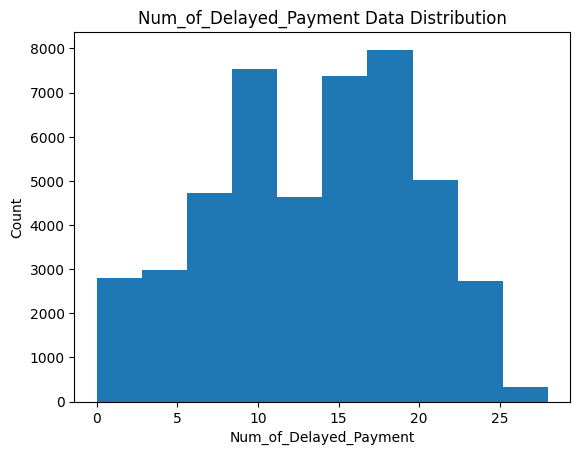

In [114]:
# Removing outliers from testing data
print('\nTesting data')
remove_outliers(test, 'Num_of_Delayed_Payment')

Now for filling the nan values we can use two methods one is to simply replace nan value with 0 and another method is to use forwardfill method. We will be using the second method because if there exists any entries with '0' then it may imply that nan values can be 0 or more.

In [115]:
# Checking the no. of entries with 0 
print('No. of Num_of_Delayed_Payment entries with 0 in training data: ',
      (train['Num_of_Delayed_Payment'] == 0).sum(), '\n')
print('No. of Num_of_Delayed_Payment entries with 0 in testing data: ',
      (test['Num_of_Delayed_Payment'] == 0).sum(), '\n')

No. of Num_of_Delayed_Payment entries with 0 in training data:  1609 

No. of Num_of_Delayed_Payment entries with 0 in testing data:  811 



In [116]:
# Filling the empty values with forward fill method
train['Num_of_Delayed_Payment'] = train['Num_of_Delayed_Payment'].fillna(method='ffill')
test['Num_of_Delayed_Payment'] = test['Num_of_Delayed_Payment'].fillna(method='ffill')

In [117]:
print(' Num_of_Delayed_Payment missing values in Train dataframe :',
      train['Num_of_Delayed_Payment'].isna().sum(), '\n' * 2,
      'Num_of_Delayed_Payment missing values in Test dataframe :',
      test['Num_of_Delayed_Payment'].isna().sum())

 Num_of_Delayed_Payment missing values in Train dataframe : 0 

 Num_of_Delayed_Payment missing values in Test dataframe : 0


### 7.9 Numerical Feature: Changed_Credit_Limit

By looking at the previous histogram, there does not seem to exist notable outliers. However, there are some missing values that need to be dealt with. In Changed_Credit_Limit feature, the eight values shared by a customer does not necessarily have to be a same value. Same as before, we will be filling in the missing values by either changing the nan values to 0 method or using forward fill method.

In [118]:
# checking if there are any Changed_Credit_Limit with 0 value
print(' Count of Changed_Credit_Limit with 0 value in Train dataframe :',
      (train['Changed_Credit_Limit'] == 0).sum(), '\n' * 2,
      'Count of Changed_Credit_Limit with 0 value in Test dataframe :',
      (test['Changed_Credit_Limit'] == 0).sum())

 Count of Changed_Credit_Limit with 0 value in Train dataframe : 4 

 Count of Changed_Credit_Limit with 0 value in Test dataframe : 2


There exists the 0 values. Therefore, we will be using the forward fill method to fill in the missing values.

In [119]:
# filling in the missing Changed_Credit_Limit values with forward fill method
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].fillna(method = 'ffill')
test['Changed_Credit_Limit'] = test['Changed_Credit_Limit'].fillna(method = 'ffill')

# checking if there are still missing values in the Changed_Credit_Limit feature
print(' Changed_Credit_Limit missing values in Train dataframe :',
      train['Changed_Credit_Limit'].isnull().sum(), '\n' * 2,
      'Changed_Credit_Limit missing values in Test dataframe :',
      test['Changed_Credit_Limit'].isnull().sum())

 Changed_Credit_Limit missing values in Train dataframe : 0 

 Changed_Credit_Limit missing values in Test dataframe : 0


### 7.9 Numerical Feature: Num_Credit_Inquiries

By looking at the previous histogram, there exists some outliers in the Num_Credit_Inquiries feature, with upper outliers the most obvious. There are missing values as well. Let's deal with the outliers first.

In [120]:
# Counting outliers
print('Training data')
count_outliers(train, 'Num_Credit_Inquiries')

print('\nTesting data')
count_outliers(test, 'Num_Credit_Inquiries')

Training data
Total outlier counts:  1650

Testing data
Total outlier counts:  846


Num_Credit_Inquiries  data distribution after dropping outliers


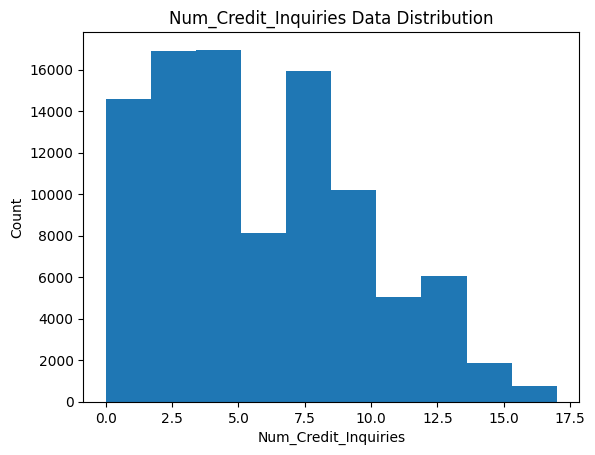

In [121]:
# Dropping outliers in training data
remove_outliers(train, 'Num_Credit_Inquiries')

Num_Credit_Inquiries  data distribution after dropping outliers


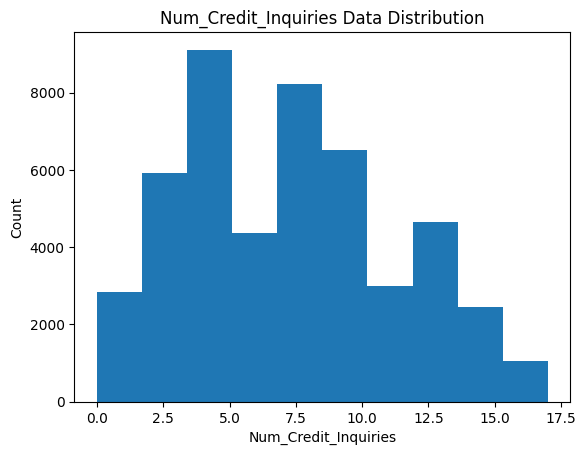

In [122]:
# Dropping outliers in testing data
remove_outliers(test, 'Num_Credit_Inquiries')

Same as before we will fill missing value with forward fill method

In [123]:
# Filling missing values with ffill mehtod
train['Num_Credit_Inquiries'] = train['Num_Credit_Inquiries'].fillna(method='ffill')
test['Num_Credit_Inquiries'] = test['Num_Credit_Inquiries'].fillna(method='ffill')

# checking if there are still missing values in the Num_Credit_Inquiries feature
print(' Num_Credit_Inquiries missing values in Train dataframe :',
      train['Num_Credit_Inquiries'].isnull().sum(), '\n' * 2,
      'Num_Credit_Inquiries missing values in Test dataframe :',
      test['Num_Credit_Inquiries'].isnull().sum())

 Num_Credit_Inquiries missing values in Train dataframe : 0 

 Num_Credit_Inquiries missing values in Test dataframe : 1


There is still 1 missing value in testing dataframe, let's check it out.

In [124]:
test.loc[test['Num_Credit_Inquiries'].isnull()]

,ID,Customer_ID,Month,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan
0,0x160a,CUS_0xd40,September,24.0,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4,"[Auto Loan, Credit-Builder Loan, Personal Loan...",3,7.0,11.27,NaN,Good,809.98,35.030402,273.0,No,49.574949,236.642682,Low_spent_Small_value_payments,186.266702,True,True,False,True,False,False,False,True,False


In [125]:
tempDf = test.groupby('Customer_ID').get_group('CUS_0xd40')
tempDf[['Customer_ID', 'Num_Credit_Inquiries']]

,Customer_ID,Num_Credit_Inquiries
0,CUS_0xd40,NaN
1,CUS_0xd40,4.0
2,CUS_0xd40,4.0
3,CUS_0xd40,4.0


Seems like ffill method didn't work for this record because the first entry is itself NaN. So, instead we will use the counterpart of ffill method, bfill

In [126]:
#. Filling the NaN in test data with bfill method
test['Num_Credit_Inquiries'] = test.groupby('Customer_ID')['Num_Credit_Inquiries'].fillna(method='bfill')

In [127]:
# Checking if there are still NaN values left or not
test.loc[test['Num_Credit_Inquiries'].isnull()]

,ID,Customer_ID,Month,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan,Student Loan


### 7.10 Numerical Feature: Credit_History_Age

By looking at the previous histogram, there does not seem to exist notable outliers. However, there are some missing values that need to be dealt with. In Credit_History_Age feature, the eight values shared by a customer does not necessarily have to be a same value. In fact, the values shared by each customer act differently compared to the values in other features.

Train Dataframe

In [128]:
# creating a list containing index with step value of 8 to locate the start of each customer
# range start
start = 0
# range stop: the number of the entries
stop = len(train)
# range step: the number of entries for each customer
step = len(train[train['Customer_ID'] == train['Customer_ID'].unique()[0]])
# defining CustomerIndexer
CustomerIndexer = range(start, stop, step)

# start of the moving index
i = 0

# iterating through each customer to fill the missing values
for indexstart, ID in zip(CustomerIndexer, train['Customer_ID'].unique()):
    
    # dealing with the first n missing values
    
    i = indexstart # index start for each new customer
    
    # while the beginning entry of the current customer is still empty
    while i > -1 and np.isnan(train['Credit_History_Age'][indexstart]) == True:
        if np.isnan(train['Credit_History_Age'][i]) == True: # encountering missing value
            i = i + 1
        else: # encountering filled entry
            train['Credit_History_Age'][i - 1] = train['Credit_History_Age'][i] - 1
            i = i - 1
    
    # dealing with the rest of the missing values
    
    i = indexstart # restarting the loop from the current customer's first entry
    
    # while i is still in bound and the Customer_ID is according to the current cuustomer
    while i < len(train['Customer_ID']) and train['Customer_ID'][i] == ID:
        if np.isnan(train['Credit_History_Age'][i]) == False: # encountering filled entry
            i = i + 1
        else: # encountering missing value
            train['Credit_History_Age'][i] = train['Credit_History_Age'][i - 1] + 1
            i = i + 1

# checking if there are still missing values in the Credit_History_Age feature
print('Credit_History_Age missing values in Train dataframe :',
      train['Credit_History_Age'].isnull().sum())

/var/folders/v8/s752sg95209c7mrl_31hp1k80000gp/T/ipykernel_4645/1338883708.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Credit_History_Age'][i] = train['Credit_History_Age'][i - 1] + 1
/var/folders/v8/s752sg95209c7mrl_31hp1k80000gp/T/ipykernel_4645/1338883708.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Credit_History_Age'][i - 1] = train['Credit_History_Age'][i] - 1


Credit_History_Age missing values in Train dataframe : 0


Testing dataframe

In [129]:
# creating a list containing index with step value of 4 to locate the start of each customer
# range start
start = 0
# range stop: the number of the entries
stop = len(test)
# range step: the number of entries for each customer
step = len(test[test['Customer_ID'] == test['Customer_ID'].unique()[0]])
# defining CustomerIndexer
CustomerIndexer = range(start, stop, step)

# start of the moving index
i = 0

# iterating through each customer to fill the missing values
for indexstart, ID in zip(CustomerIndexer, test['Customer_ID'].unique()):
    
    # dealing with the first n missing values
    
    i = indexstart # index start for each new customer
    
    # while the beginning entry of the current customer is still empty
    while i > -1 and np.isnan(test['Credit_History_Age'][indexstart]) == True:
        if np.isnan(test['Credit_History_Age'][i]) == True: # encountering missing value
            i = i + 1
        else: # encountering filled entry
            test['Credit_History_Age'][i - 1] = test['Credit_History_Age'][i] - 1
            i = i - 1
    
    # dealing with the rest of the missing values
    
    i = indexstart # restarting the loop from the current customer's first entry
    
    # while i is still in bound and the Customer_ID is according to the current cuustomer
    while i < len(test['Customer_ID']) and test['Customer_ID'][i] == ID:
        if np.isnan(test['Credit_History_Age'][i]) == False: # encountering filled entry
            i = i + 1
        else: # encountering missing value
            test['Credit_History_Age'][i] = test['Credit_History_Age'][i - 1] + 1
            i = i + 1

# checking if there are still missing values in the Credit_History_Age feature
print('Credit_History_Age missing values in Test dataframe :',
      test['Credit_History_Age'].isnull().sum())


/var/folders/v8/s752sg95209c7mrl_31hp1k80000gp/T/ipykernel_4645/1903667256.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Credit_History_Age'][i] = test['Credit_History_Age'][i - 1] + 1
/var/folders/v8/s752sg95209c7mrl_31hp1k80000gp/T/ipykernel_4645/1903667256.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Credit_History_Age'][i - 1] = test['Credit_History_Age'][i] - 1


Credit_History_Age missing values in Test dataframe : 0


### 7.11 Numerical Feature: Total_EMI_per_month
By looking at the previous histogram, there exists some outliers in the Num_of_Loan feature, with upper outliers the most obvious. Luckily, there are no missing values. Let's deal with the outliers first.



In [130]:
# counting the outliers in Total_EMI_per_month
print(' Train dataframe :')
count_outliers(train, 'Total_EMI_per_month')
print('\nTest dataframe :')
count_outliers(test, 'Total_EMI_per_month')


 Train dataframe :
Total outlier counts:  6795

Test dataframe :
Total outlier counts:  3933


Total_EMI_per_month  data distribution after dropping outliers


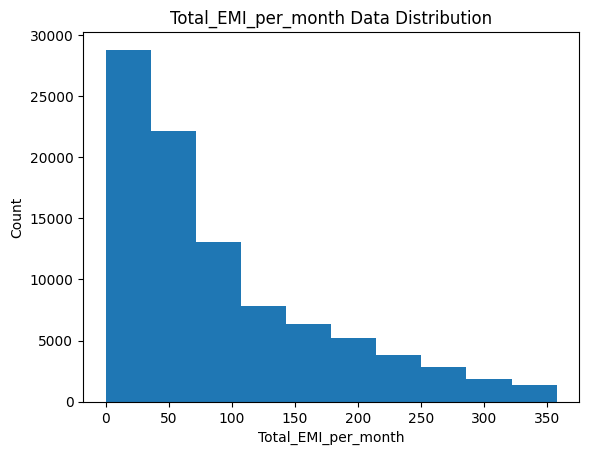

In [131]:
# dropping the outliers in Train dataframe's Total_EMI_per_month
remove_outliers(train, 'Total_EMI_per_month')

Total_EMI_per_month  data distribution after dropping outliers


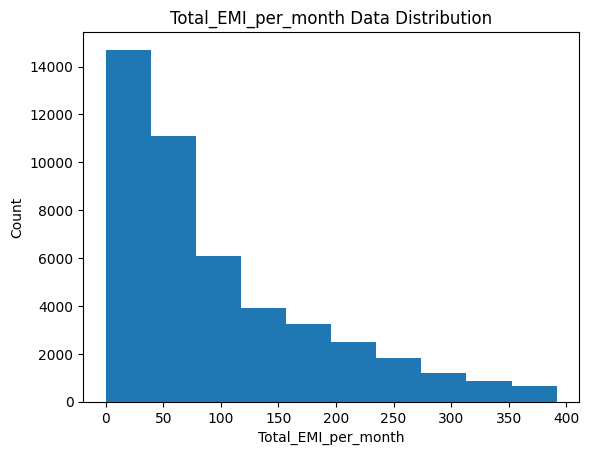

In [132]:
# dropping the outliers in Test dataframe's Total_EMI_per_month
remove_outliers(test, 'Total_EMI_per_month')

In [133]:
# replacing the Total_EMI_per_month value of each customer using each customer's Total_EMI_per_month Mode
print('Train dataframe :')
mode_replacement(train, 'Customer_ID', 'Total_EMI_per_month')

print('\nTest dataframe :')
mode_replacement(test, 'Customer_ID', 'Total_EMI_per_month')


Train dataframe :
Remaining Total_EMI_per_month missing values : 2376

Test dataframe :
Remaining Total_EMI_per_month missing values : 2148


In [134]:
# filling in the remaining Total_EMI_per_month missing values
print('Train dataframe :')
aggregrate_fill_na(train, 'Customer_ID', 'Total_EMI_per_month')

print('\nTest dataframe :')
aggregrate_fill_na(test, 'Customer_ID', 'Total_EMI_per_month')

Train dataframe :
Remaining Total_EMI_per_month missing values : 0

Test dataframe :
Remaining Total_EMI_per_month missing values : 0


### 7.12 Numerical Feature: Amount_invested_monthly
By looking at the previous histogram, there exists some outliers in the Amount_invested_monthly feature, with upper outliers the most obvious. There are missing values as well. Moreover, the eight values shared by a customer do not necessarily have to be a same value. Let's deal with the outliers first.

In [135]:
# counting the outliers in Amount_invested_monthly
print(' Train dataframe :')
count_outliers(train, 'Amount_invested_monthly')
print('\n',
      'Test dataframe :')
count_outliers(test, 'Amount_invested_monthly')

 Train dataframe :
Total outlier counts:  10096

 Test dataframe :
Total outlier counts:  5035


Amount_invested_monthly  data distribution after dropping outliers


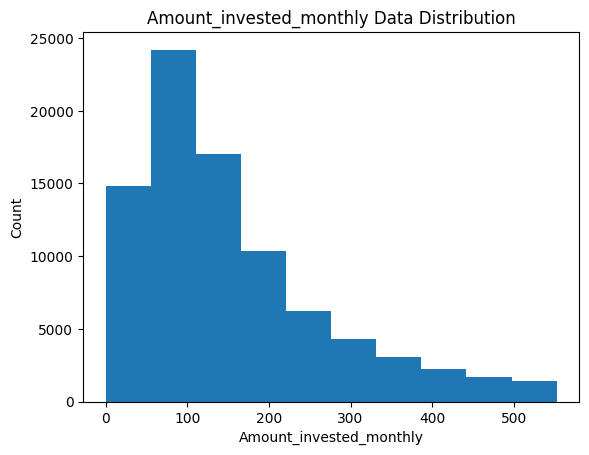

In [136]:
# dropping the outliers in Train dataframe's Amount_invested_monthly
remove_outliers(train, 'Amount_invested_monthly')

Amount_invested_monthly  data distribution after dropping outliers


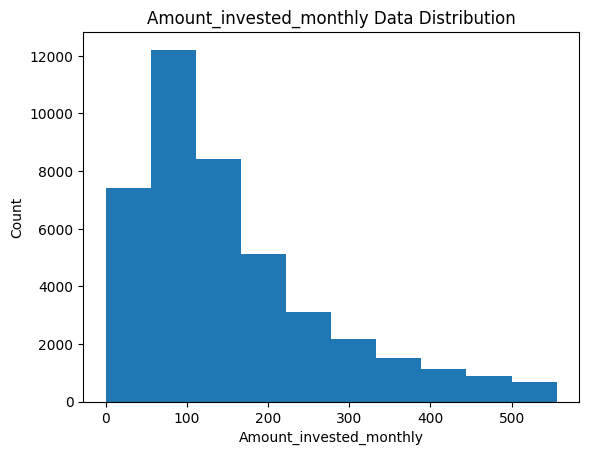

In [137]:
# dropping the outliers in Test dataframe's Amount_invested_monthly
remove_outliers(test, 'Amount_invested_monthly')

In [138]:
# checking if there are still missing values in the Amount_invested_monthly feature
print(' Amount_invested_monthly missing values in Train dataframe :',
      train['Amount_invested_monthly'].isnull().sum(), '\n' * 2,
      'Amount_invested_monthly missing values in Test dataframe :',
      test['Amount_invested_monthly'].isnull().sum())

 Amount_invested_monthly missing values in Train dataframe : 14575 

 Amount_invested_monthly missing values in Test dataframe : 7306


In [139]:
# filling in the remaining Amount_invested_monthly missing values
print('Train dataframe :')
aggregrate_fill_na(train, 'Customer_ID', 'Amount_invested_monthly')
print('\n',
      'Test dataframe :')
aggregrate_fill_na(test, 'Customer_ID', 'Amount_invested_monthly')

Train dataframe :
Remaining Amount_invested_monthly missing values : 0

 Test dataframe :
Remaining Amount_invested_monthly missing values : 0


### 7.13 Numerical Feature: Monthly_Balance
By looking at the previous histogram, there exists some outliers in the Monthly_Balance feature, with upper outliers the most obvious. There are missing values as well. Moreover, the eight values shared by a customer do not necessarily have to be a same value. Let's deal with the outliers first.

In [140]:
# counting the outliers in Monthly_Balance
print(' Train dataframe :')
count_outliers(train, 'Monthly_Balance')
print('\n',
      'Test dataframe :')
count_outliers(test, 'Monthly_Balance')

 Train dataframe :
Total outlier counts:  7516

 Test dataframe :
Total outlier counts:  3838


Monthly_Balance  data distribution after dropping outliers


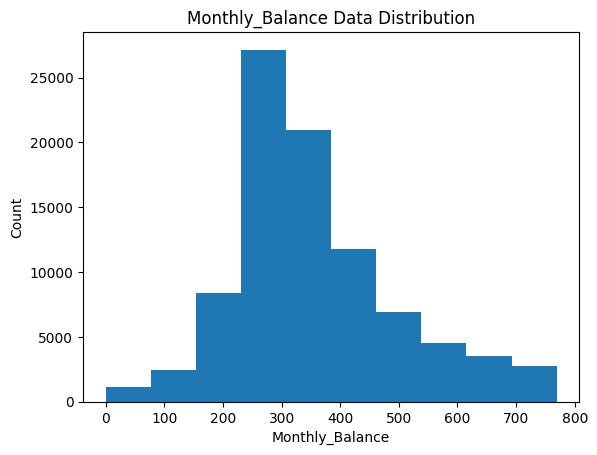

In [141]:
# dropping the outliers in Train dataframe's Monthly_Balance
remove_outliers(train, 'Monthly_Balance')

Monthly_Balance  data distribution after dropping outliers


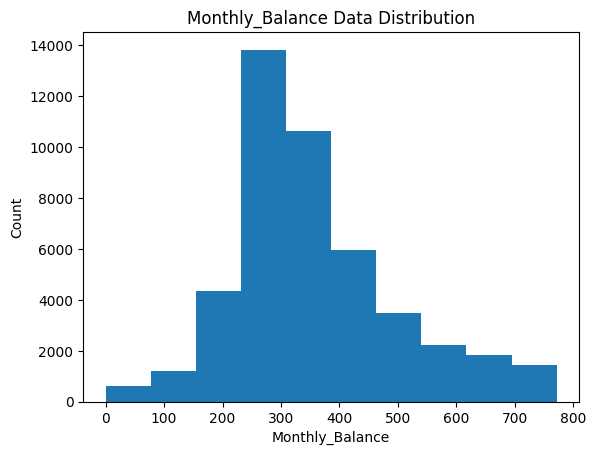

In [142]:
# dropping the outliers in Test dataframe's Monthly_Balance
remove_outliers(test, 'Monthly_Balance')

In [143]:
# filling in the remaining Monthly_Balance missing values
print('Train dataframe :')
aggregrate_fill_na(train, 'Customer_ID', 'Monthly_Balance')
print('\n',
      'Test dataframe :')
aggregrate_fill_na(test, 'Customer_ID', 'Monthly_Balance')

Train dataframe :
Remaining Monthly_Balance missing values : 0

 Test dataframe :
Remaining Monthly_Balance missing values : 0


In [144]:
# saving the checkpoint
train_ver_6 = train.copy()
test_ver_6 = test.copy()

In [145]:
# Saving processed data to .csv file
train_ver_6.to_csv('processed_train.csv', index=False)
test_ver_6.to_csv('processed_test.csv', index=False)

# Part 2:  Classification Model building
</br>

### 1. Importing ML libraries

In [146]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

### 2. Importing the processed dataset

In [147]:
# Importing the processed dataset
train = pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')

### 3. Dropping unwanted columns

In [148]:
train.columns

Index(['ID', 'Customer_ID', 'Month', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan',
       'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan',
       'Personal Loan', 'Student Loan', 'Credit_Score'],
      dtype='object')

In [149]:
# Dropping unwanted columns
drop_col_list = ['ID', 'Customer_ID', 'SSN', 'Not Specified', 'Type_of_Loan']
train.drop(drop_col_list, axis=1, inplace=True)
test.drop(drop_col_list, axis=1, inplace=True)

### 4. Encoding categorical data

In [150]:
# Encoding Month
train['Month'] = train['Month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 
                                     'July':7, 'August':8})
test['Month'] = test['Month'].map({'September':9, 'October':10, 'November':11, 'December':12})

In [151]:
# Encoding Occupation
occupation_encoder = LabelEncoder()
train['Occupation'] = occupation_encoder.fit_transform(train['Occupation'])
test['Occupation'] = occupation_encoder.fit_transform(test['Occupation'])
occupation_encoder.classes_

array(['Accountant', 'Architect', 'Developer', 'Doctor', 'Engineer',
       'Entrepreneur', 'Journalist', 'Lawyer', 'Manager', 'Mechanic',
       'Media_Manager', 'Musician', 'Scientist', 'Teacher', 'Writer'],
      dtype=object)

In [152]:
# Encoding Credit_Mix
Credit_Mix_encoder = LabelEncoder()
train['Credit_Mix'] = Credit_Mix_encoder.fit_transform(train['Credit_Mix'])
test['Credit_Mix'] = Credit_Mix_encoder.fit_transform(test['Credit_Mix'])
Credit_Mix_encoder.classes_

array(['Bad', 'Good', 'Standard'], dtype=object)

In [153]:
# Encoding Payment_Behaviour
Payment_Behaviour_encoder = LabelEncoder()
train['Payment_Behaviour'] = Payment_Behaviour_encoder.fit_transform(train['Payment_Behaviour'])
test['Payment_Behaviour'] = Payment_Behaviour_encoder.fit_transform(test['Payment_Behaviour'])
Payment_Behaviour_encoder.classes_

array(['High_spent_Large_value_payments',
       'High_spent_Medium_value_payments',
       'High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments'], dtype=object)

In [154]:
# Encoding Payment_of_Min_Amount
Payment_of_Min_Amount_encoder = LabelEncoder()
train['Payment_of_Min_Amount'] = Payment_of_Min_Amount_encoder.fit_transform(train['Payment_of_Min_Amount'])
test['Payment_of_Min_Amount'] = Payment_of_Min_Amount_encoder.fit_transform(test['Payment_of_Min_Amount'])
Payment_of_Min_Amount_encoder.classes_

array(['NM', 'No', 'Yes'], dtype=object)

### 5. Splitting Train and Test data

In [155]:
X = train.drop('Credit_Score', axis=1)
Y = train['Credit_Score']

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=4)

### 6. Scoring function

In [157]:
evaluation = dict()
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    evaluation[str(model_name)] = [train_accuracy, test_accuracy]
    print('=='*10)
    print(str(model_name))
    print('--'*10)
    print('Training acc: ', round((train_accuracy*100), 2))
    print('Testing acc : ', round((test_accuracy*100), 2))
    print('=='*10)
    
    actual = y_test
    predicted = model.predict(X_test)
    conf_mat = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, 
                                                display_labels = ['Poor', 'Standard','Good'])
    cm_display.plot()
    plt.show()

### 7. Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression

In [159]:
lr = LogisticRegression(C=0.01, solver='liblinear')
lr

LogisticRegression(C=0.01, solver='liblinear')

In [160]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [161]:
lr_score_train = lr.score(X_train, y_train)
lr_score_train

0.6250428571428571

In [162]:
lr_score_test = lr.score(X_test, y_test)
lr_score_test

0.6253333333333333

Logistic Regression
--------------------
Training acc:  62.5
Testing acc :  62.53


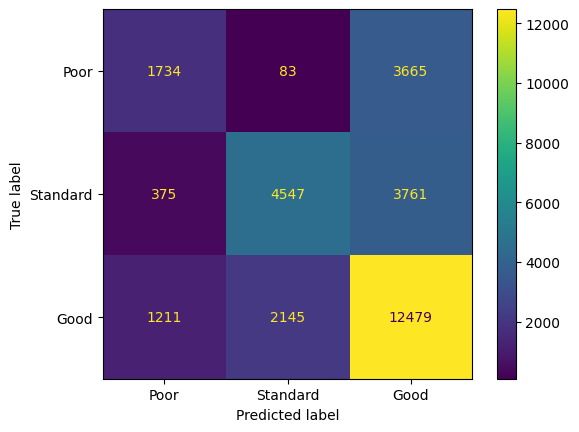

In [163]:
evaluate_model(lr, 'Logistic Regression', X_train, X_test, y_train, y_test)

### 8. KNN

In [164]:
from sklearn.neighbors import KNeighborsClassifier

In [165]:
knn = KNeighborsClassifier()
knn

KNeighborsClassifier()

In [166]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [167]:
knn_score_train=knn.score(X_train, y_train)
knn_score_train

0.8362142857142857

In [168]:
knn_score_test = knn.score(X_test, y_test)
knn_score_test

0.7471333333333333

KNN
--------------------
Training acc:  83.62
Testing acc :  74.71


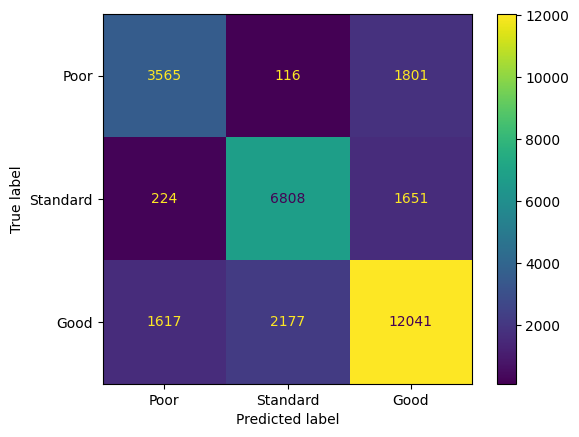

In [169]:
evaluate_model(knn, 'KNN', X_train, X_test, y_train, y_test)

### 9. Decision Tree

In [170]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [171]:
decisionTree = DecisionTreeClassifier(criterion='entropy', max_depth=12)
decisionTree

DecisionTreeClassifier(criterion='entropy', max_depth=12)

In [172]:
decisionTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=12)

In [173]:
decTree_score_train = decisionTree.score(X_train, y_train)
decTree_score_train

0.7504

In [174]:
decTree_score_test = decisionTree.score(X_test, y_test)
decTree_score_test

0.7079333333333333

Decision Tree
--------------------
Training acc:  75.04
Testing acc :  70.79


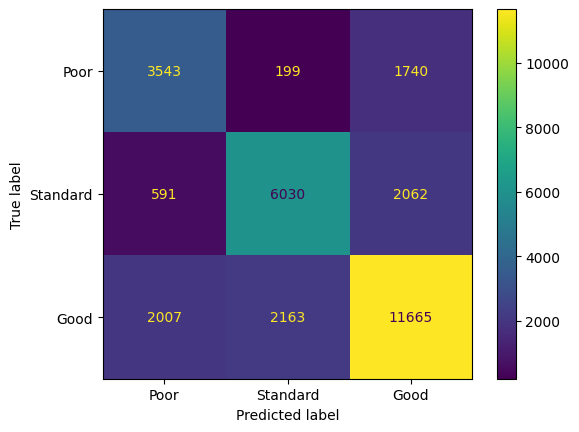

In [175]:
evaluate_model(decisionTree, 'Decision Tree', X_train, X_test, y_train, y_test)

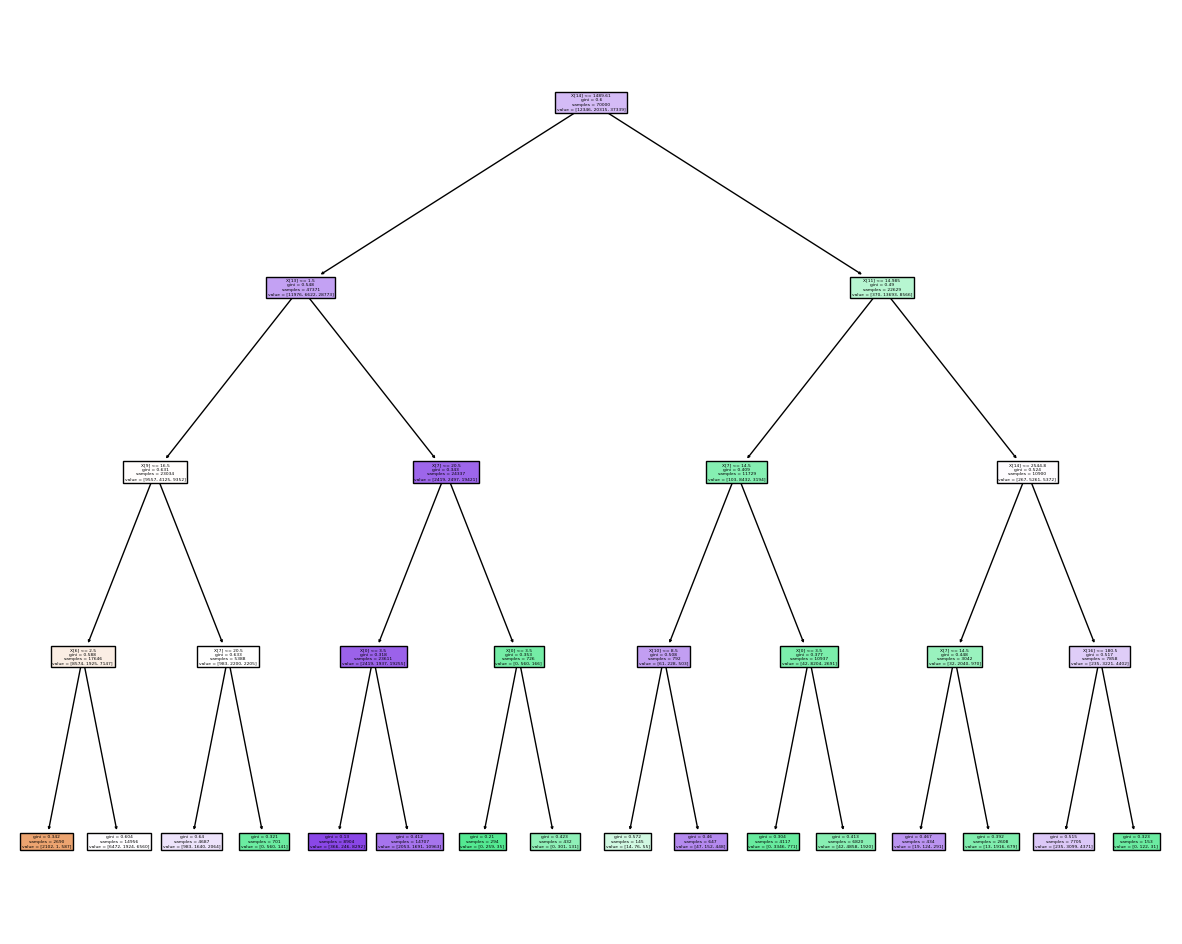

In [176]:
dtt = DecisionTreeClassifier(max_depth=4)
dtt.fit(X_train, y_train)
fig = plt.figure(figsize=(15,12))
tree.plot_tree(dtt , filled=True)
plt.show()

### 10. Random Forest

In [177]:
from sklearn.ensemble import RandomForestClassifier

In [178]:
rf = RandomForestClassifier(max_features=15 , max_depth=12)
rf

RandomForestClassifier(max_depth=12, max_features=15)

In [179]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features=15)

In [180]:
rf_score_train=rf.score(X_train , y_train)
rf_score_train

0.7771142857142858

In [181]:
rf_score_test=rf.score(X_test , y_test)
rf_score_test

0.7362

RandomForestClassifier
--------------------
Training acc:  77.71
Testing acc :  73.62


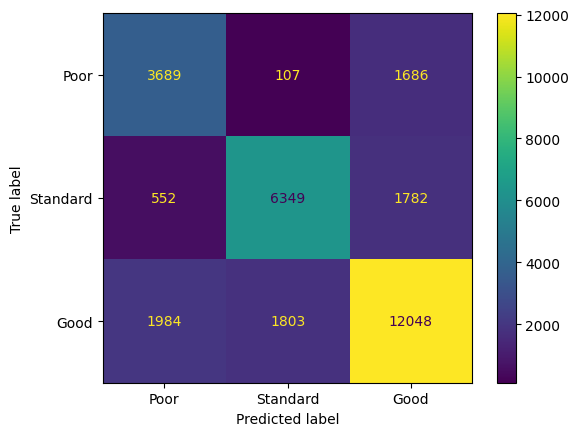

In [182]:
evaluate_model(rf, "RandomForestClassifier", X_train, X_test, y_train, y_test)

### 11. Voting

In [183]:
from sklearn.ensemble import VotingClassifier

In [184]:
clf1 = LogisticRegression(C = 100)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = DecisionTreeClassifier(max_features=14 ,    max_depth=12)
clf4 = RandomForestClassifier(max_features=15 , max_depth=12)

In [185]:
voting = VotingClassifier(estimators=[('LogisticRegression', clf1), ('KNN', clf2), 
                                      ('DecisionTree', clf3), ('RandomForest', clf4)])
voting

VotingClassifier(estimators=[('LogisticRegression', LogisticRegression(C=100)),
                             ('KNN', KNeighborsClassifier(n_neighbors=7)),
                             ('DecisionTree',
                              DecisionTreeClassifier(max_depth=12,
                                                     max_features=14)),
                             ('RandomForest',
                              RandomForestClassifier(max_depth=12,
                                                     max_features=15))])

In [186]:
voting.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('LogisticRegression', LogisticRegression(C=100)),
                             ('KNN', KNeighborsClassifier(n_neighbors=7)),
                             ('DecisionTree',
                              DecisionTreeClassifier(max_depth=12,
                                                     max_features=14)),
                             ('RandomForest',
                              RandomForestClassifier(max_depth=12,
                                                     max_features=15))])

In [187]:
voting_score_train=voting.score(X_train , y_train)
voting_score_train

0.7866571428571428

In [188]:
voting_score_test=voting.score(X_test , y_test)
voting_score_test

0.7465333333333334

Voting
--------------------
Training acc:  78.67
Testing acc :  74.65


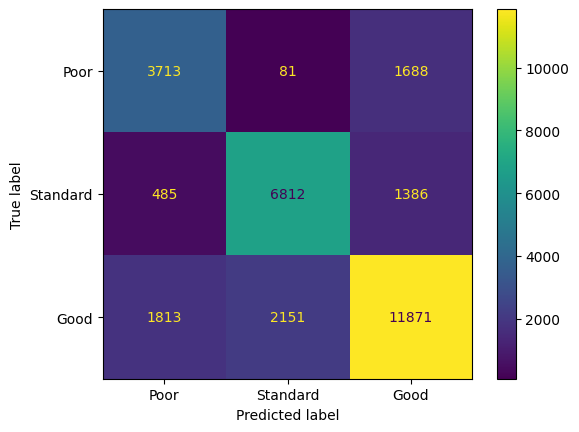

In [189]:
evaluate_model(voting, "Voting", X_train, X_test, y_train, y_test)

### 11. Comparison

In [190]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']
data = [[lr_score_train, lr_score_test] , [knn_score_train, knn_score_test],
        [decTree_score_train, decTree_score_train], [rf_score_train, rf_score_test]]
cols = ["Train score" , "Test score"]
pd.DataFrame(data=data , index= models , columns= cols).sort_values(ascending= False , by = ["Test score","Train score"])

,Train score,Test score
Decision Tree,0.750400,0.750400
KNN,0.836214,0.747133
Random Forest,0.777114,0.736200
Logistic Regression,0.625043,0.625333


## References

<h3>Kaggle notebook referred: <br><br>
1. <a href="https://www.kaggle.com/code/arvynathaniel/credit-score-classification-cleaning-ml#Data-Science-Project:-Credit-Score-Classification"> Credit Score classification (Cleaning + ML)</a> by <a href="https://www.kaggle.com/arvynathaniel">Arvy Nathaniel</a> <br><br>
2. <a href="https://www.kaggle.com/code/abdelaziznabil/credit-score-classification-80-score-7-models"> Credit score classification 80% score 7 models</a> by <a href="https://www.kaggle.com/abdelaziznabil">Arvy Nathaniel</a>
        
</h3>